In [1]:
%pylab inline
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import time, sys
from IPython.display import clear_output
from scipy import stats
import scipy.stats
import scipy.optimize as opt
import scipy.io
from mpl_toolkits.axisartist.axislines import Subplot
# %load_ext jupyternotify
#Progress bar function
import time, sys
import numpy.fft as fft
from ipywidgets import interact,interactive,fixed,interact_manual
import ipywidgets as widgets

def update_progress(progress):
    barLength = 100 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()

Populating the interactive namespace from numpy and matplotlib


In [409]:
#define F-test function
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f,p
# We have functions to convert proportion correct to z scores and vice versa
def ztop(z):
    p=0.5 * (1.0+scipy.special.erf(z/np.sqrt(2) ) )
    return p

def ptoz(p):
    if p==1:
        p=0.9999999
    elif p==0:
        p=0.0000001
    z=np.sqrt(2) * scipy.special.erfinv( 2*p-1.0)
    return z

def ptozM(p,M=4):
    if p==1:
        p=0.999999
    elif p==0:
        p=0.0001
    # from JEK Smith 1982. Checked to match tables of Hacker/Ratcliff
    K_M=0.86-0.085 * np.log(M-1)
    d=K_M*np.log( (M-1)*p/(1-p) )
    return d

# Function for getting bootstrapped zscores
def bootstrap_corr_to_z(df,num_boot=1000):
    z_scores=[]
    for i in range(num_boot):
        resampled_df=df.sample(len(df),replace=True)
        zVal=ptozM(resampled_df.mean())
        z_scores.append(zVal)
    return z_scores

# Function for getting bootstrapped prop values from 0/1 correct/incorrect response list
def bootstrap_corr_to_propCor(df,num_boot=1000):
    propCor=[]
    for i in range(num_boot):
        resampled_df=df.sample(len(df),replace=True)
        propCor.append(resampled_df.mean())
    return propCor

## Perumutation Test
def perm_test(c,t,num_perm,method='mean',z_score=True,*args):
    k=[]
    # Look if there are additional groups passed in
    if len(args)>1:
        t1=args[0]
        t2=agrs[1]
                
    if method=='mean':
        if z_score==True:
            diff=(ptozM(np.mean(c))-ptozM(np.mean(t)))
        else:
            diff=((np.mean(c))-(np.mean(t)))
        z=np.concatenate([c,t])
        for i in range(num_perm):
            np.random.shuffle(z)
            # Since the number of samples in each group is unequal we would match the
            # distribution to the individual lengths of each data series
            if z_score==True:
                k.append((ptozM(np.mean(z[:int(len(c))])) - ptozM(np.mean(z[int(len(c)):]))))  
            else:
                k.append(((np.mean(z[:int(len(c))])) - (np.mean(z[int(len(c)):]))))  
        
    elif method=='ttest':
        # Compare between two sets of measures/data
        diff=stats.ttest_ind(c,t).statistic
        z=np.concatenate([c,t])
        for i in range(num_perm):
            np.random.shuffle(z)
            # Since the number of samples in each group is unequal we would match the
            # distribution to the individual lengths of each data series
            tval=stats.ttest_ind(z[:int(len(c))],z[int(len(c)):])
            k.append(tval.statistic)
        
    elif method=='ftest':
        for arg in args:
            t2=arg
        if 't2' in locals():
            # Compare between more than two sets of measures/data
            diff,p_val=stats.f_oneway(c,t,t2).statistic
            z=np.concatenate([c,t,t2])
            for i in range(num_perm):
                np.random.shuffle(z)
                # Since the number of samples in each group is unequal we would match the
                # distribution to the individual lengths of each data series
                g1=z[:int(len(c))]
                g2=z[int(len(c)):(int(len(c))+int(len(t)))]
                g3=z[(int(len(c))+int(len(t))):]
                fval=stats.f_oneway(g1,g2,g3).statistic
                k.append(fval)
        else:
            # Compare between  two sets of measures/data
            diff,p_val=f_test(c,t)
            z=np.concatenate([c,t])
            for i in range(num_perm):
                np.random.shuffle(z)
                # Since the number of samples in each group is unequal we would match the
                # distribution to the individual lengths of each data series
                g1=z[0:int(len(c))]
                g2=z[int(len(c))::]
                fval,p_val=f_test(g1,g2)
                k.append(fval)
        
    elif method=='friedman':
        # compare between two sets of measures/data
        diff=stats.friedmanchisquare(c,t,t1,t2).statistic
        z=np.concatenate([c,t,t1,t2])
        for i in range(num_perm):
            np.random.shuffle(z)
            # Since the number of samples in each group is unequal we would match the
            # distribution to the individual lengths of each data series
            len_df=len(c) # since lengths of groups are the same we use one of them
            g1=z[0:len_df]
            g2=z[len_df*1:len_df*2]
            g3=z[len_df*2:len_df*3]
            g4=z[len_df*3:len_df*4]
            friedman_test=stats.friedmanchisquare(g1,g2,g3,g4)
            k.append(friedman_test.statistic)
    if method=='mean':
        if diff>0: # when the original difference is positive
            p_value=len(np.where(k>=diff)[0])/num_perm
        elif diff<0: # when the original difference is negative
            p_value=len(np.where(k<=diff)[0])/num_perm
        elif diff==0 and np.mean(k)>0: # when the original difference is zero and distribution is positive
            p_value=len(np.where(k<=diff)[0])/num_perm
        elif diff==0 and np.mean(k)<0:# when the original difference is zero and distribution is negative
            p_value=len(np.where(k>=diff)[0])/num_perm
        else:# It wouldnt normally get here but just to prevent bugs
            p_value=1
    else: # all other test statistic
        if diff<np.mean(k):
            p_value=len(np.where(k<=diff)[0])/num_perm
        elif diff>np.mean(k):
            p_value=len(np.where(k>=diff)[0])/num_perm
    
    # check if p_value exists, if not assign it a high value
    if 'p_value' not in locals():
        print('UnboundLocalError')
        p_value=1
    
            
    return {"diff":diff,"k":k,'p_val':p_value}

# GENERAL EQUATION ------------------------------------------------------------
#1. We use an exponential fit
#2. Or we use a weibull fit
def func(x, A, c, d):
    return A*np.exp(c*x) + d
# Wikipedia Weibull CDF https://en.wikipedia.org/wiki/Weibull_distribution
def func_weibull(x,lamb,k,lr):
    guess=0.25
    weibull_cdf=(1-np.exp(- (x/lamb)**k) )
    yval=guess+(1.0-guess-lr)*weibull_cdf
    return yval

In [3]:
if sys.platform=='win32':
#     data_directory='Z:\TSLO_Experiment\VoluntaryMicrosaccade\Experiment2ObliqueMicrosaccadeWNeutral'
    data_directory='Z:\TSLO_Experiment\VoluntaryMicrosaccade\Experiment2ObliqueMicrosaccadeWNeutral'
elif sys.platform=='linux':
    data_directory='/home/coateslab/LabData/TSLO_Experiment/VoluntaryMicrosaccade/Experiment1AllFlankers/'
filedir_list=[]
for root,dirs,file in os.walk(data_directory):
    if "Videos" in root and "Processed" not in root and "Pilot" not in root and "Training" not in root:
        filedir_list.append(root)

behav_compile=True
if behav_compile==True:
    # we get the path for the inidividual behavioral data files
    if sys.platform=='win32':
        behavdata_dir='Z:\TSLO_Experiment\VoluntaryMicrosaccade\Experiment2ObliqueMicrosaccadeWNeutral'
    elif sys.platform=='linux':
        behavdata_dir='/home/coateslab/LabData/TSLO_Experiment/VoluntaryMicrosaccade/Experiment1AllFlankers/'
    behavdir_list=[]
    for root,dirs,file in os.walk(behavdata_dir):
        if "Behav"in root and "Pilot" not in root and "Training" not in root:
            behavdir_list.append(root)
        
# Saccade data compilation
# % time
# This cell compiles the saccade metrics obtained from the ReVAS eye position filters and saccade(and drift) detection functions
# In this case we obtain the saccade and drift metrics from the mat files that are created by ReVAS
failedMicroSacc=[]
microSaccData=[]
driftData=[]
create_pickle= False
# while create_dataframe==True:
num_elements=len(filedir_list)
counter=0
for foldername in filedir_list:
    update_progress(counter/num_elements)
    counter+=1
    failedMicroSacc=os.listdir(foldername)
    filelist=os.listdir(foldername)
    subj_id=foldername[foldername.find("S0"):(foldername.find("S0")+3)]
    for filename in filelist:
        if 'sacsdrifts' in filename:
            try:
                # First we load the mat file into jupyter
                mat=scipy.io.loadmat(os.path.join(foldername,filename))
                # we get the foldername from the filepath
    #             folderdate=foldername.replace('/mnt/hd/ao/vids/','')
                # initially we create empty pandas dataframes
                tempSaccData=pd.DataFrame({'Duration':[],'onsetIdx':[],'offsetIdx':[],'onsetTime':[],'offsetTime':[],'xAmp':[],'yAmp':[]\
                                           ,'VectorAmp':[],'Direction':[],'peakVel':[],'meanVel':[]})
                # 1. form saccade dataset for the file
                if mat['params']['saccades'][0,0]==0 or len((mat['params']['saccades'][0,0]))==0 or (mat['params']['saccades'][0,0].size)==0:
                    tempSaccData=tempSaccData.append({'Duration':np.nan,'onsetIdx':np.nan,'offsetIdx':np.nan,'onsetTime':np.nan,\
                                                      'offsetTime':np.nan,'xAmp':np.nan,'yAmp':np.nan,\
                                                      'VectorAmp':np.nan,'Direction':np.nan,'peakVel':np.nan,'meanVel':np.nan},ignore_index=True)
                else:
                    # we determine the size of the saccade array
                    tempSaccData=pd.DataFrame({'Duration':[],'onsetIdx':[],'offsetIdx':[],'onsetTime':[],'offsetTime':[],'xAmp':[],'yAmp':[]\
                                           ,'VectorAmp':[],'Direction':[],'peakVel':[],'meanVel':[]})

                    saccArraySize=mat['params']['saccades'][0,0]['duration'].size # for now use one of the fields of the struct array
                    durationList=[]
                    onsetIdxList=[]
                    offsetIdxList=[]
                    onsetTimeList=[]
                    offsetTimeList=[]
                    xAmpList=[]
                    yAmpList=[]
                    VectorAmpList=[]
                    DirectionList=[]
                    peakVelList=[]
                    maxVelList=[]
                    for itemIdx in range(saccArraySize): #here we would want to unapack each item from the struct and append it to a list 
                        duration=(mat['params']['saccades'][0,0]['duration'][itemIdx].flatten().item().item())
                        onsetIdx=(mat['params']['saccades'][0,0]['onsetIndex'][itemIdx].flatten().item().item())
                        offsetIdx=(mat['params']['saccades'][0,0]['offsetIndex'][itemIdx].flatten().item().item())
                        onsetTime=((mat['params']['saccades'][0,0]['onsetTime'][itemIdx].flatten().item().item()))
                        offsetTime=(mat['params']['saccades'][0,0]['offsetTime'][itemIdx].flatten().item().item())
                        xAmp=(mat['params']['saccades'][0,0]['xAmplitude'][itemIdx].flatten().item().item())
                        yAmp=(mat['params']['saccades'][0,0]['yAmplitude'][itemIdx].flatten().item().item())
                        VectorAmp=(mat['params']['saccades'][0,0]['vectorAmplitude'][itemIdx].flatten().item().item())
                        Direction=(mat['params']['saccades'][0,0]['direction'][itemIdx].flatten().item().item())
                        peakVel=(mat['params']['saccades'][0,0]['peakVelocity'][itemIdx].flatten().item().item())
                        maxVel=(mat['params']['saccades'][0,0]['meanVelocity'][itemIdx].flatten().item().item())

                        tempSaccData=tempSaccData.append({'Duration':duration,'onsetIdx':onsetIdx,'offsetIdx':offsetIdx,'onsetTime':onsetTime,\
                                  'offsetTime':offsetTime,'xAmp':xAmp,'yAmp':yAmp,'VectorAmp':VectorAmp,'Direction':Direction\
                                  ,'peakVel':peakVel,'meanVel':maxVel},ignore_index=True)
                # We finally add file details to the data structure which can later be used to 
                # query into the dataframe
                tempSaccData['filename']=filename
                trialCode='%s'%(filename[0:filename.find('_Video')])
                if "_2.5_" in trialCode:
                    trialCode=trialCode.replace("_2.5_","_2.50_")
                tempSaccData['code']=trialCode
                tempSaccData['subj_id']=subj_id
                if 'NoMicrosaccade' in filename:
                    tempSaccData['microsaccade_cond']='NoMicrosaccade'
                else:
                    tempSaccData['microsaccade_cond']='Microsaccade'
    #             tempSaccData['foldername']=folderdate
    #             tempSaccData['code']='%s_%s'%(folderdate,filename[0:filename.find('_Eye')])
                #The temporary data is then appended to the bigger data structure 
                microSaccData.append(tempSaccData)
            except:
                failedMicroSacc.append(os.path.join(foldername,filename))
# create_dataframe=True
microSaccData=pd.concat(microSaccData)
# we then remove the saccade data with NaNs
microSaccFiltered=microSaccData[microSaccData['Direction'].notnull()]

# Drift data compilation
# % time
# This cell compiles the saccade metrics obtained from the ReVAS eye position filters and saccade(and drift) detection functions
# In this case we obtain the saccade and drift metrics from the mat files that are created by ReVAS
failedDrifts=[]
driftData=[]
create_pickle= False
# while create_dataframe==True:
num_elements=len(filedir_list)
counter=0
for foldername in filedir_list:
    update_progress(counter/num_elements)
    counter+=1
    failedMicroSacc=os.listdir(foldername)
    filelist=os.listdir(foldername)
    subj_id=foldername[foldername.find("S0"):(foldername.find("S0")+3)]
    for filename in filelist:
        if 'sacsdrifts' in filename:
            try:
                # First we load the mat file into jupyter
                mat=scipy.io.loadmat(os.path.join(foldername,filename))
                # we get the foldername from the filepath
    #             folderdate=foldername.replace('/mnt/hd/ao/rotVids/','')
                # initially we create empty pandas dataframes
                tempDriftData=pd.DataFrame({'Duration':[],'onsetIdx':[],'offsetIdx':[],'onsetTime':[],'offsetTime':[],'xAmp':[],'yAmp':[]\
                                           ,'VectorAmp':[],'Direction':[],'peakVel':[],'meanVel':[]})
                # 1. form saccade dataset for the file
                if mat['params']['drifts'][0,0]==0 or len((mat['params']['drifts'][0,0]))==0 or (mat['params']['drifts'][0,0].size)==0:
                    tempDriftData=tempSaccData.append({'Duration':np.nan,'onsetIdx':np.nan,'offsetIdx':np.nan,'onsetTime':np.nan,\
                                                      'offsetTime':np.nan,'xAmp':np.nan,'yAmp':np.nan,\
                                                      'VectorAmp':np.nan,'Direction':np.nan,'peakVel':np.nan,'meanVel':np.nan},ignore_index=True)
                else:
                    # we determine the size of the saccade array
                    tempSaccData=pd.DataFrame({'Duration':[],'onsetIdx':[],'offsetIdx':[],'onsetTime':[],'offsetTime':[],'xAmp':[],'yAmp':[]\
                                           ,'VectorAmp':[],'Direction':[],'peakVel':[],'meanVel':[]})

                    driftArraySize=mat['params']['drifts'][0,0]['duration'].size # for now use one of the fields of the struct array
                    durationList=[]
                    onsetIdxList=[]
                    offsetIdxList=[]
                    onsetTimeList=[]
                    offsetTimeList=[]
                    xAmpList=[]
                    yAmpList=[]
                    VectorAmpList=[]
                    DirectionList=[]
                    peakVelList=[]
                    maxVelList=[]
                    for itemIdx in range(driftArraySize): #here we would want to unapack each item from the struct and append it to a list 
                        duration=(mat['params']['drifts'][0,0]['duration'][itemIdx].flatten().item().item())
                        onsetIdx=(mat['params']['drifts'][0,0]['onsetIndex'][itemIdx].flatten().item().item())
                        offsetIdx=(mat['params']['drifts'][0,0]['offsetIndex'][itemIdx].flatten().item().item())
                        onsetTime=((mat['params']['drifts'][0,0]['onsetTime'][itemIdx].flatten().item().item()))
                        offsetTime=(mat['params']['drifts'][0,0]['offsetTime'][itemIdx].flatten().item().item())
                        xAmp=(mat['params']['drifts'][0,0]['xAmplitude'][itemIdx].flatten().item().item())
                        yAmp=(mat['params']['drifts'][0,0]['yAmplitude'][itemIdx].flatten().item().item())
                        VectorAmp=(mat['params']['drifts'][0,0]['vectorAmplitude'][itemIdx].flatten().item().item())
                        Direction=(mat['params']['drifts'][0,0]['direction'][itemIdx].flatten().item().item())
                        peakVel=(mat['params']['drifts'][0,0]['peakVelocity'][itemIdx].flatten().item().item())
                        maxVel=(mat['params']['drifts'][0,0]['meanVelocity'][itemIdx].flatten().item().item())

                        tempDriftData=tempDriftData.append({'Duration':duration,'onsetIdx':onsetIdx,'offsetIdx':offsetIdx,'onsetTime':onsetTime,\
                                  'offsetTime':offsetTime,'xAmp':xAmp,'yAmp':yAmp,'VectorAmp':VectorAmp,'Direction':Direction\
                                  ,'peakVel':peakVel,'meanVel':maxVel},ignore_index=True)
                # We finally add file details to the data structure which can later be used to 
                # query into the dataframe
                tempDriftData['filename']=filename
                trialCode='%s'%(filename[0:filename.find('_Video')])
                if "_2.5_" in trialCode:
                    trialCode=trialCode.replace("_2.5_","_2.50_")
                tempSaccData['code']=trialCode
                tempDriftData['subj_id']=subj_id
                if 'NoMicrosaccade' in filename:
                    tempDriftData['microsaccade_cond']='NoMicrosaccade'
                else:
                    tempDriftData['microsaccade_cond']='Microsaccade'
    #             tempDriftData['foldername']=folderdate
    #             tempDriftData['code']='%s_%s'%(folderdate,filename[0:filename.find('_Eye')])

                #The temporary data is then appended to the bigger data structure 
                driftData.append(tempDriftData)
            except:
                failedMicroSacc.append(os.path.join(foldername,filename))
#     create_dataframe=False
driftData=pd.concat(driftData)
# we then remove the saccade data with NaNs
driftDataFiltered=driftData[driftData['Direction'].notnull()]
  

if behav_compile==True:
    # Behav Data compilation
    behavdir_listles=[]
    behavData=[]
    questData=[]

    num_elements=len(behavdir_list)
    for foldername in behavdir_list:
        # we find subject ID
        subj_id=foldername[foldername.find('S0'):foldername.find('S0')+3]
        filelist=os.listdir(foldername)
        for filename in filelist:
            try:
                if 'Crowding' in filename and 'CrowdingQuest' not in filename and 'CrowdingThresh' not in filename:
                    # First we load the mat file into jupyter
                    tempBehav=pd.read_csv(os.path.join(foldername,filename))
                    tempBehav['filename']=filename
                    if "NoMicrosaccade" not in filename:
                        trialCode='%s_Microsaccade'%(filename[0:filename.find('_Crowding')])
                    else:
                        trialCode='%s'%(filename[0:filename.find('_Crowding')])
                    tempBehav['code']=trialCode
                    tempBehav['subj_id']=subj_id
                    if 'NoMicrosaccade' in filename and '_valid' in filename:
                        tempBehav['microsaccade_cond']='NoMicrosaccade_valid'
                    elif 'NoMicrosaccade' in filename and '_invalid' in filename:
                        tempBehav['microsaccade_cond']='NoMicrosaccade_invalid'
                    elif 'NoMicrosaccade' not in filename and '_valid' in filename:
                        tempBehav['microsaccade_cond']='Microsaccade_valid'
                    elif 'NoMicrosaccade' not in filename and '_invalid' in filename:
                        tempBehav['microsaccade_cond']='Microsaccade_invalid'
                    #The temporary data is then appended to the bigger data structure 
                    behavData.append(tempBehav)
                elif "CrowdingThresh" in filename:
                    #We again load data into jupyter
                    tempData=pd.read_csv(os.path.join(foldername,filename))
                    tempData['subj_id']=subj_id
                    # ///rly we build the dataframe
                    questData.append(tempData)
            except:
                print(filename)
    if len(questData)!=0:
        questData=pd.concat(questData)
    behavData=pd.concat(behavData)
    
    
# Marker data compilation
failedFiles=[]
markerData=[]
markerFixNeeded=True
# while create_dataframe==True:
counter=0
num_elements=len(filedir_list)
for foldername in filedir_list:
#     update_progress(counter/num_elements)
    counter+=1
    filelist=os.listdir(foldername)
    subj_id=foldername[foldername.find("S0"):(foldername.find("S0")+3)]
    for filename in filelist:
        if 'marker' in filename and 'markerData' not in filename:
            # First we load the mat file into jupyter
            tempData=pd.read_csv(os.path.join(foldername,filename),names=['frameIdx','stripIdx'])
            tempData['stimulusOnsetTime']=(tempData['frameIdx']*(1000/30)/1000)+(tempData['stripIdx']*(1000/16000)/1000)
            if markerFixNeeded==True:
                if len(tempData)!=2: # Cases where marker is missing we get values from behav data
                    if "NoMicrosaccade" in filename:
                        trialCode='%s'%(filename[0:filename.find('_Video')])
                    else:
                        trialCode='%s'%(filename[0:filename.find('_Microsaccade')])
                    # Get this from the marker file, since the first marker would correspond to the cue onset. 
                    # The second missing one would correspond to the target onset
                    if len(tempData)>0:
                        cueOnsetTime=tempData['stimulusOnsetTime'].iloc[0]
                        # We get the behavioral data from the trial
                        behavDataTrial=behavData.query("code==@trialCode")
                        if len(behavDataTrial)>0: # valid ones
                            # We get this from behavioral data
                            cueDuration=behavDataTrial['cueDuration'].iloc[0]
                            # Using the two we figure out when the target happened
                            targetOnsetTime=cueOnsetTime+cueDuration
                            # We create a df with dummy strip values & calculation target onset time
                            markerFix=pd.DataFrame([[np.nan,np.nan,targetOnsetTime]],columns=['frameIdx','stripIdx','stimulusOnsetTime'])
                            # We finally append this to existing marker data
                            tempData=tempData.append(markerFix)


            tempData['filename']=filename
            tempData['code']='%s'%(filename[0:filename.find('_Video')])

            tempData['subj_id']=subj_id
            if 'NoMicrosaccade' in filename:
                tempData['microsaccade_cond']='NoMicrosaccade'
            else:
                tempData['microsaccade_cond']='Microsaccade'
            #The temporary data is then appended to the bigger data structure 
            markerData.append(tempData)
            
markerData=pd.concat(markerData)

ValueError: No objects to concatenate

In [604]:
data_dir='D:\KSP\Study\Houston\Projects\TSLOExperiments\TSLOData\CrowdingVoluntaryMicrosaccade\Experiment2_oblique\Data'
os.chdir(data_dir)
#eyepos=pd.read_csv("eyepos.csv", error_bad_lines=False,encoding='ISO-8859-1')
microSaccFiltered=pd.read_csv("saccData.csv")
driftData=pd.read_csv("driftData.csv")
behavData=pd.read_csv("behavData.csv")
markerData=pd.read_csv("markerData.csv")
relSaccData=pd.read_csv("relSaccData.csv")
zScore_sacc=pd.read_csv("zScore_sacc.csv")
zScore_nosacc=pd.read_csv("ZScore_nosacc.csv")
y_model_df=pd.read_csv("y_model_df.csv")
fit_paramsDF=pd.read_csv("fit_paramsDF.csv")
CS_df=pd.read_csv("CS_df.csv")
# we create the saccade dataframes
## Filter trials based on microsaccadic activity\n",

#A temoporal cut-off is set & trials with micrsaccades in that time window are grouped as trials with microsaccades & the rest as trials without microsaccades
# We set the value that would be used to distinguish between saccade & no saccade trials
# no microsaccade trials
behavDataNoMicrosaccadeWsaccades=list(behavData.query("microsaccade_cond=='NoMicrosaccade_valid' or microsaccade_cond=='NoMicrosaccade_invalid'")['code'])
NoMicroSaccadeFailedTrial=relSaccData.query("code==@behavDataNoMicrosaccadeWsaccades and relStimTime>-0.300")['code']
behavDataNoMicrosaccade=behavData[behavData.code.isin(behavDataNoMicrosaccadeWsaccades)]
behavDataNoMicrosaccade=behavDataNoMicrosaccade.query("trialValidity=='valid'")
# saccade Trials
behavDataSaccadeList=list(behavData.query("microsaccade_cond=='Microsaccade_valid' or microsaccade_cond=='Microsaccade_invalid'")['code'])
saccadeTrials=relSaccData.query("code==@behavDataSaccadeList")
saccadeData=pd.merge(saccadeTrials,behavData,left_on='code',right_on='code',copy=False)
# The saccade directions range from -180 to +180 and uses the atan2d function in matlab. So to retrieve values that range between 0 and 360 we add 360 for values that\n",
# are below 0
saccadeData['DirectionPolar']=0
for i in range(len(saccadeData)):
    if saccadeData['Direction'].iloc[i]<0:
        saccadeData['DirectionPolar'].iloc[i]=saccadeData['Direction'].iloc[i]+360
    else:
        saccadeData['DirectionPolar'].iloc[i]=saccadeData['Direction'].iloc[i]
# here we segregate the microsaccade data based on whether they were leftward or rightward.
# Criterion is based on Baumeler et al. 2020
# Krish June 21': Modified this to include only saccades 45° away from horizontal meridian
# rightupSacc=relSaccDataMerged.query("DirectionPolar<85")
# rightdownSacc=relSaccDataMerged.query("(DirectionPolar>275)")
# rightwardSacc=rightupSacc.append(rightdownSacc)
# rightwardSacc['leftVright']='right'
# leftwardSacc=relSaccDataMerged.query("(DirectionPolar>95) & (DirectionPolar<265)")
# leftwardSacc['leftVright']='left'
# leftVrightData=leftwardSacc.append(rightwardSacc)     
# leftVrightData['congruent']= np.where((leftVrightData['stim_loc'] == leftVrightData['leftVright']),1 ,0)


c:\Users\krish\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## Relative Saccade dataframe

In [601]:
#Compiles microsaccades that occurs following the last stimulus onset
codeList=microSaccFiltered['code'].unique()
relSaccData=[]
relStimTime=[]
relSacc=[]
for acode in codeList:
    try:
        lastStimTime=markerData.query("code==@acode")['stimulusOnsetTime'].iloc[1]
        # get only saccades that occur after final stimulus
        # We try to get only the first microsaccade that occurs after stimulus onset
        tempSacc=microSaccFiltered.query("code==@acode & @lastStimTime<onsetTime<(@lastStimTime+0.600) & VectorAmp>0.15")
        if len(tempSacc)>0:
            sacc=tempSacc['onsetTime'].iloc[0]
            relSaccTime=sacc-lastStimTime
            relSacc.append(relSaccTime)
        tempSacc['lastStimTime']=lastStimTime
        tempSacc['relOnsetTime']=tempSacc['onsetTime']-lastStimTime
        # get stimulus time relative to saccade onset
        if len(tempSacc)>0:
            saccOnsetTime=tempSacc['onsetTime'].iloc[0]
            relStimOnsetTime=lastStimTime-saccOnsetTime
            relStimTime.append(relStimOnsetTime)
        tempSacc['relStimTime']=relStimOnsetTime
        # we add only the first microsaccade to the saccade array
        relSaccData.append(tempSacc.head(1))
    except (IndexError,NameError) as e:
        pass
relSaccData=pd.concat(relSaccData)


c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

## Filter task relevant microsaccades

In [ ]:
# Filter saccade data based on relative stimulus onset time
sacc200msOnsetDF=saccadeData.query("relStimTime>-0.200 & trialValidity=='valid'")
# We will also filter them based on saccade direction wrt to stimulus location
stimLoc_UL=sacc200msOnsetDF.query("stim_loc=='upperLeft' and 90<DirectionPolar<180")
stimLoc_UR=sacc200msOnsetDF.query("stim_loc=='upperRight' and 0<DirectionPolar<90")
stimLoc_LL=sacc200msOnsetDF.query("stim_loc=='lowerLeft' and 180<DirectionPolar<270")
stimLoc_LR=sacc200msOnsetDF.query("stim_loc=='lowerRight' and 270<DirectionPolar<360")
sacc200msOnsetDF=pd.concat([stimLoc_UL,stimLoc_UR,stimLoc_LL,stimLoc_LR])

### Filter microsaccades based on main sequence trend

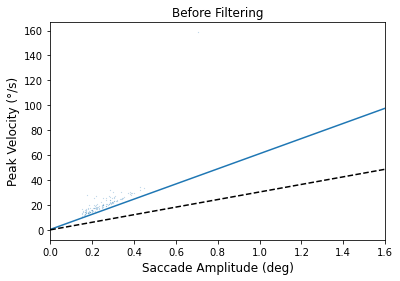

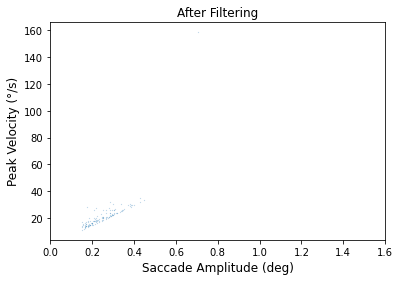

In [606]:
# We filter saccade events from every trial
# 1. Only use saccade events with Duration>15 ms and Duration<80ms 
# 2. We also filter data to use samples that fall on the main sequence/remove outliers(artifacts from saccade detectio method)
saccFiltered=saccFiltered.query("0.015<Duration<0.080")

#Only use samples that fall along the main sequence plot and show linear relationship
x=(sacc.VectorAmp.values)
y=(saccFiltered.peakVel.values)
xMax=1.6
# First get edges from histogram
num_bins=75
counts, yedges, xedges = np.histogram2d(y, x, bins=num_bins)
# counts, yedges, xedges = np.histogram2d(y, x, bins=num_bins,range=[[0,np.max(y)], [0,np.max(x)]])
#Hough transform
from skimage.transform import hough_line, hough_line_peaks
h, theta, d = hough_line(counts)
#Plot output
plt.figure()
plt.scatter(x, y,s=.01)
plt.xlim(0,xMax)
#line x & y values
x_vals=[]
y_vals=[]
slope_vals=[]
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (y0,x0) = dist * np.array([np.cos(angle), np.sin(angle)])

    orig_slope=np.tan(angle + np.pi/2)
    new_x0=x0/num_bins*(xedges[-2])
    new_y0=y0/num_bins*(yedges[-2])
    new_slope=orig_slope*(np.max(yedges)/np.max(xedges))
    plt.axline((new_x0, new_y0), slope=new_slope)
    x_vals.append(new_x0)
    y_vals.append(new_y0)
    slope_vals.append(new_slope)
# We get the mid-point
x_mid=np.sum(x_vals)/2
y_mid=np.sum(y_vals)/2
slope_mid=np.sum(slope_vals)/2
# we draw line in between
plt.axline((x_mid,y_mid),slope=slope_mid,color='k',ls='--')

plt.xlabel('Saccade Amplitude (deg)',size=12)
plt.ylabel('Peak Velocity (°/s)',size=12)
plt.title('Before Filtering')

plt.figure()
below_line=y>(slope_mid*x)
x_filtered=x[below_line]
y_filtered=y[below_line]
plt.scatter(x_filtered,y_filtered,s=.01)
# Also get rejected data which we can also use to plot
below_line=y<(slope_mid*x)
x_reject=x[below_line]
y_reject=y[below_line]
plt.xlabel('Saccade Amplitude (deg)',size=12)
plt.ylabel('Peak Velocity (°/s)',size=12)
plt.title("After Filtering")
plt.xlim(0,xMax)
# #Finally we tweak the saccade dataframe to use the filtered values
saccFiltered=saccFiltered.loc[saccFiltered['VectorAmp'].isin(x_filtered)]
sacc_rejected=saccFiltered.loc[saccFiltered['VectorAmp'].isin(x_reject)]

## Microsaccade direction

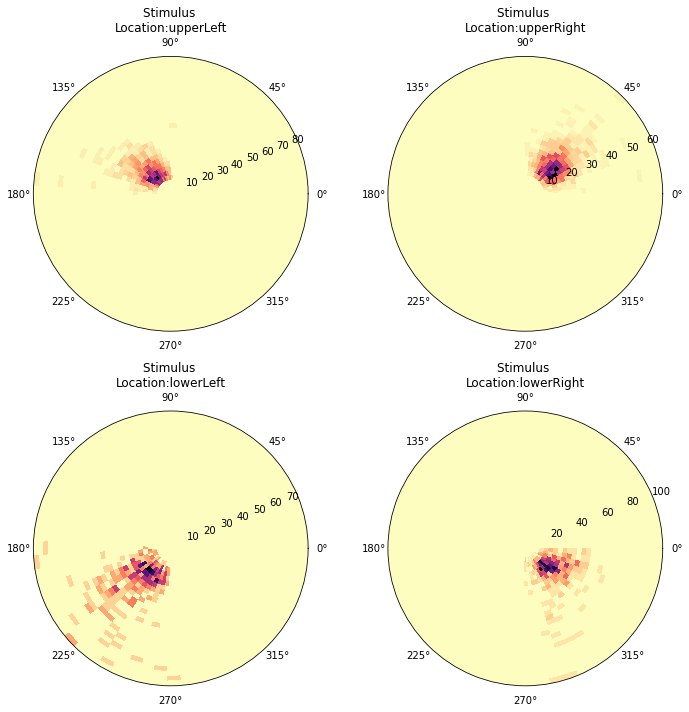

In [ ]:
fig,axs=plt.subplots(2,2,subplot_kw={'projection':'polar'},figsize=(10,10))
counter=0
stimLocs=['upperLeft','upperRight','lowerLeft','lowerRight']
heatmap=True
for row in axs:
    for col in row:
        astim=stimLocs[counter]
        # two input arrays
        data=saccFiltered.query("stim_loc==@astim & trialValidity=='valid' & relStimTime>-0.200")
        arr=np.radians(data['DirectionPolar'])
        radius=data['VectorAmp']*60
        N = 50

        # We set bins based on stimulus location/pad accordingly
        # create theta for 24 hours
        if astim=='upperRight':
            theta = np.linspace(0.0, np.pi/2, N, endpoint=False)
        elif astim=='upperLeft':
            theta = np.linspace(np.pi/2, np.pi, N, endpoint=False)
        elif astim=='lowerLeft':
            theta = np.linspace(np.pi, (3*np.pi)/2, N, endpoint=False)
        elif astim=='lowerRight':
            theta = np.linspace((3*np.pi)/2, 2*np.pi, N, endpoint=False)
        if heatmap==True:
            # define binning
            rbins = np.linspace(0,radius.max(), 30)
            abins = np.linspace(0,2*np.pi, 60)
            #calculate histogram
            hist, _, _ = np.histogram2d(arr, radius, bins=(abins, rbins))
            A, R = np.meshgrid(abins, rbins)
            pc = col.pcolormesh(A, R, hist.T, cmap="magma_r")
        else:
            bottom = 2

            # make the histogram that bined on 24 hour
            radii, tick = np.histogram(arr, bins = N)

            # width of each bin on the plot
            width = (2*np.pi) / N

            bars = col.bar(theta, radii, width=width, bottom=bottom)

            # set the lable go clockwise and start from the top
            col.set_theta_zero_location("E")
            # counter-clockwise
            col.set_theta_direction(1)

            # set the label
            ticks = ['0', '45°', '90°', '135°', '180°', '225°', '270°', '315°']
            col.set_xticklabels(ticks)
            col.set_ylim(0,40)
        #Column title
        col.set_title("Stimulus \nLocation:%s"%(astim))
        counter+=1
fig.tight_layout()
plt.savefig("..\Plots\MicrosaccadeDirectionVStimLoc.pdf",dpi=1200,bbox_inches='tight')

In [ ]:
saccFiltered.groupby("stim_loc")['corr'].count()

stim_loc
lowerLeft      416
lowerRight     538
upperLeft      818
upperRight    1030
Name: corr, dtype: int64

Text(0, 0.5, 'Y Position (arcmin)')

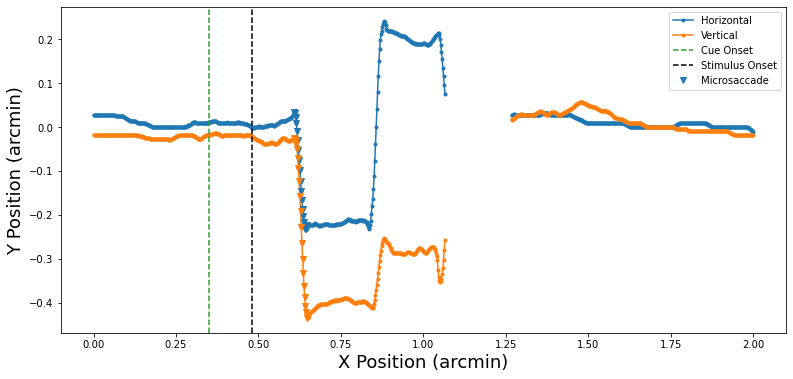

In [13]:
os.chdir("D:\\KSP\\Study\\Houston\\Workshops\\AO Psychophysics\\2022\\Presentation")
eyepos_file=scipy.io.loadmat("S01_S2_T0089_ecc_0.23_spacing_100_SOA_0.050_valid_Microsaccade_Video_02_16_2022_14_14_30_offsetdata_2022217227_Filtered.mat")
eyepos=pd.DataFrame(eyepos_file['eyeposFiltered'])
eyepos=eyepos.rename(columns={0:'xpos',1:'ypos',2:'time'})
data=eyepos
code='S01_S2_T0089_ecc_0.23_spacing_100_SOA_0.050_valid_Microsaccade'
stimTime=markerData.query("code==@code")
SaccFiltered=saccadeData.query("code==@code")
driftFiltered=driftData.query("code==@code")
plt.figure(figsize=(13,6))
plt.plot(data['time'],data['xpos'],'.-',label='Horizontal')
plt.plot(data['time'],data['ypos'],'.-',color='C1',label='Vertical')
plt.axvline(x=stimTime['stimulusOnsetTime'].iloc[0],ymin=0,ymax=1,ls='--',color='C2',label='Cue Onset')
plt.axvline(x=stimTime['stimulusOnsetTime'].iloc[1],ymin=0,ymax=1,ls='--',color='k',label='Stimulus Onset')

if len(SaccFiltered)>0:
    for i in range(len(SaccFiltered)):
        startTime=SaccFiltered['onsetTime'].iloc[i]
        endTime=SaccFiltered['offsetTime'].iloc[i]
        filteredData=data.query("time>@startTime & time<@endTime")
        x=filteredData['time']
        y1=filteredData['xpos']
        y2=filteredData['ypos']
        plt.plot(x,y1,'v',color='C0',label='Microsaccade' if i==0 else "")
        plt.plot(x,y2,'v',color='C1')

plt.legend()
plt.xlabel('X Position (arcmin)', size=18)
plt.ylabel('Y Position (arcmin)', size=18)

# plt.savefig('SampleEyeTrace2DwithEvents.png',dpi=300,bbox_tight=True)

## Stimulus onset frequency distribution relative to saccade onset

c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_tight" which is no longer supported as of 3.3 and will become an error two minor releases later
  


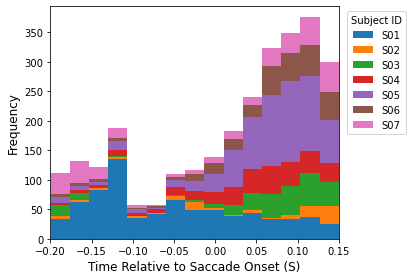

In [ ]:
df=saccFiltered
plt.hist([df.query("subj_id_x=='S01'")['relStimTime'],df.query("subj_id_x=='S02'")['relStimTime'],df.query("subj_id_x=='S03'")['relStimTime'],df.query("subj_id_x=='S04'")['relStimTime'],df.query("subj_id_x=='S05'")['relStimTime'],df.query("subj_id_x=='S06'")['relStimTime'],df.query("subj_id_x=='S07'")['relStimTime']],stacked=True,bins=15,label=['S01','S02','S03','S04','S05','S06','S07'])
plt.legend(title='Subject ID',bbox_to_anchor=(1.25,1))
plt.xlabel("Time Relative to Saccade Onset (S)",size=12)
plt.ylabel("Frequency",size=12)
plt.tight_layout()
plt.xlim(-0.2,0.150)
plt.savefig("..\Plots\stimuliOnsetRelativetoSaccade.svg",dpi=1200,bbox_tight='inches')

## Saccade charecteristics combined plot

c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_tight" which is no longer supported as of 3.3 and will become an error two minor releases later


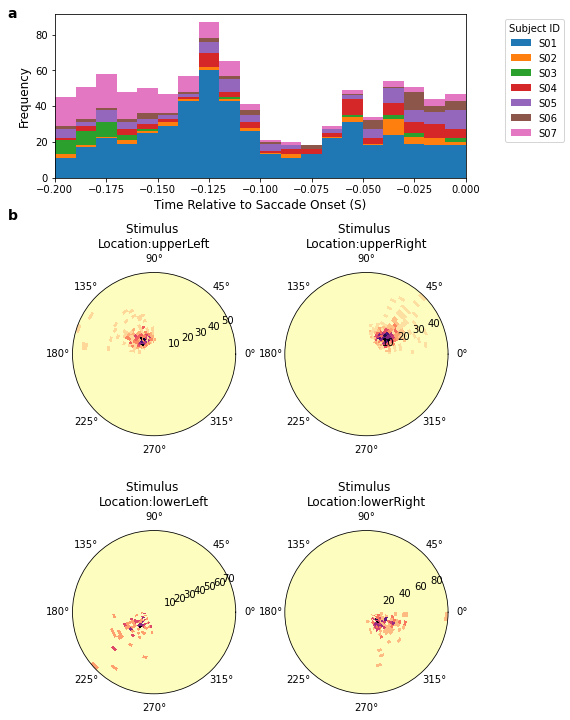

In [ ]:
stimLocs=['upperLeft','upperRight','lowerLeft','lowerRight']
fig=plt.figure(figsize=(8,10))
for idx in range(4):
    if idx==0:
        fig.add_subplot(3,2,3,projection='polar')
    elif idx==1:
        fig.add_subplot(3,2,4,projection='polar')
    elif idx==2:
        fig.add_subplot(3,2,5,projection='polar')
    elif idx==3:
        fig.add_subplot(3,2,6,projection='polar')    
    astim=stimLocs[idx]
    # two input arrays
    data=saccFiltered.query("stim_loc==@astim & trialValidity=='valid'")
    arr=np.radians(data['DirectionPolar'])
    radius=data['VectorAmp']*60
    N = 50

    # We set bins based on stimulus location/pad accordingly
    # create theta for 24 hours
    if astim=='upperRight':
        theta = np.linspace(0.0, np.pi/2, N, endpoint=False)
    elif astim=='upperLeft':
        theta = np.linspace(np.pi/2, np.pi, N, endpoint=False)
    elif astim=='lowerLeft':
        theta = np.linspace(np.pi, (3*np.pi)/2, N, endpoint=False)
    elif astim=='lowerRight':
        theta = np.linspace((3*np.pi)/2, 2*np.pi, N, endpoint=False)
    # define binning
    rbins = np.linspace(0,radius.max(), 30)
    abins = np.linspace(0,2*np.pi, 60)
    #calculate histogram
    hist, _, _ = np.histogram2d(arr, radius, bins=(abins, rbins))
    A, R = np.meshgrid(abins, rbins)
    pc = plt.pcolormesh(A, R, hist.T, cmap="magma_r")

    #Column title
    plt.title("Stimulus \nLocation:%s"%(astim))
fig.add_subplot(3,1,1)
df=sacc200msOnsetDF
plt.hist([df.query("subj_id_x=='S01'")['relStimTime'],df.query("subj_id_x=='S02'")['relStimTime'],df.query("subj_id_x=='S03'")['relStimTime'],df.query("subj_id_x=='S04'")['relStimTime'],df.query("subj_id_x=='S05'")['relStimTime'],df.query("subj_id_x=='S06'")['relStimTime'],df.query("subj_id_x=='S07'")['relStimTime']],stacked=True,bins=20,label=['S01','S02','S03','S04','S05','S06','S07'])
plt.legend(title='Subject ID',bbox_to_anchor=(1.25,1))
plt.xlabel("Time Relative to Saccade Onset (S)",size=12)
plt.ylabel("Frequency",size=12)
plt.xlim(-0.2,0)
plt.tight_layout()
fig.text(0,0.98,r'$\bf{a}$',size=14)
fig.text(0,0.7,r'$\bf{b}$',size=14)

plt.savefig("..\Plots\MicrosaccadeCharecteristcs.tiff",dpi=1200,bbox_tight='inches')

## Psychometric functions

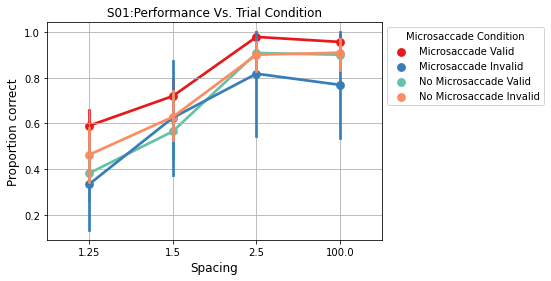

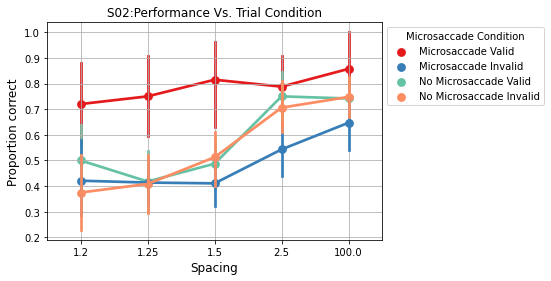

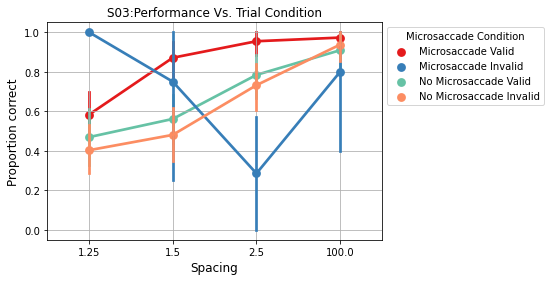

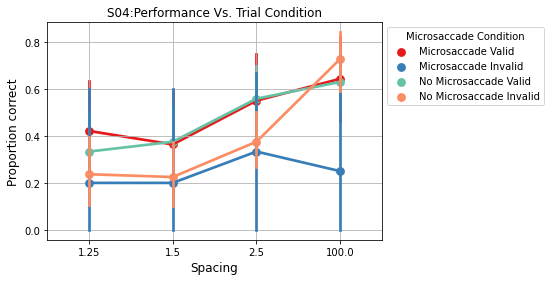

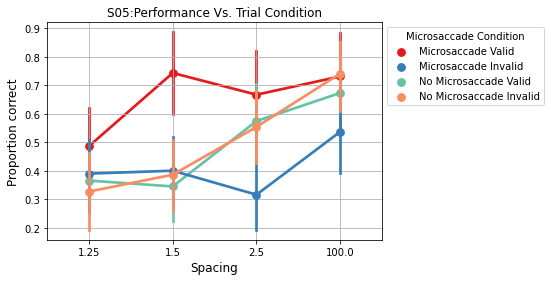

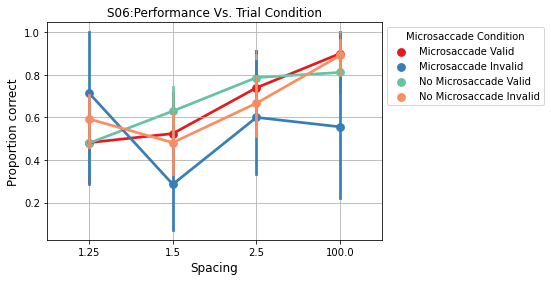

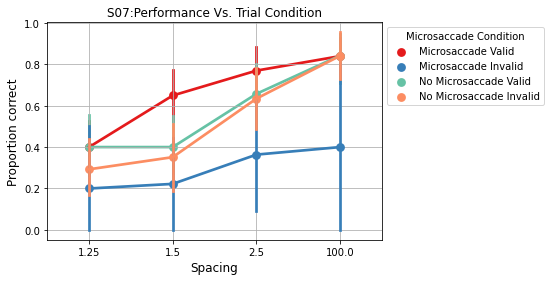

In [80]:
subs=behavData.subj_id.unique()
for asub in subs:
    plt.figure()
    hueOrder_filtered=['valid','invalid']
    ax=sns.pointplot(data=sacc200msOnsetDF.query("subj_id_x==@asub"),x='spacing',y='corr',hue="trialValidity",palette='Set1',hue_order=hueOrder_filtered)
    ax=sns.pointplot(data=behavDataNoMicrosaccade.query("subj_id==@asub"),x='spacing',y='corr',hue="trialValidity",palette='Set2',hue_order=hueOrder_filtered)
    leg_handles = ax.get_legend_handles_labels()[0]
    ax.legend(leg_handles, ['Microsaccade Valid', 'Microsaccade Invalid','No Microsaccade Valid','No Microsaccade Invalid'], title='Microsaccade Condition',bbox_to_anchor=(1,1))
    plt.ylabel("Proportion correct",size=12)
    plt.xlabel("Spacing",size=12)
    plt.title("%s:Performance Vs. Trial Condition"%(asub),size=12)
    plt.grid()

In [ ]:
#Saccade DF 
sacc200msOnsetDF=saccFiltered.query("relStimTime>-0.200")

# we do the same thing as earlier but for each subject individually and create a df with critical spacings
# First step is to get a function
# Have a function that pulls in the X & Y values from df, fits the data and get the Critical spacing
def fit_and_get_CS(df,x_lin):
    # First sort the x & y values from the DF
    x_all=df['spacing'].unique()
    y_all=df.groupby('spacing')['corr'].mean().values
    x_all.sort()
    y_all.sort()
    #optimize fit 
    p0 = [3.5, 2,0.05]
    w,_=opt.curve_fit(func_weibull,x_all,y_all,p0=p0,bounds=(0,[10, 10,1]),maxfev=10000)
    # model fit
    y_model=func_weibull(x_lin,*w)
    # Compute Critical Spacing (CS)
    CS=np.interp(0.75*np.max(y_model), y_model,x_lin)
    # Also add interpolated 50% of asymptotic level
    fifty_percent_interp=np.interp(0.50*np.max(y_model), y_model,x_lin)
    # return the paramters
    return w,y_model,CS,fifty_percent_interp
# we first create the empty arrays that will be filling inside the loop
y_model_sacc_list=np.array([])
y_model_nosacc_list=np.array([])
x_lin_list=np.array([])
CS_sacc_list=np.array([])
CS_nosacc_list=np.array([])
ecc_array=np.array([])
sub_list=np.array([])
# Get the fit parameters too
w1_lambda_list=np.array([])
w1_k_list=np.array([])
w1_lr_list=np.array([])
w2_lambda_list=np.array([])
w2_k_list=np.array([])
w2_lr_list=np.array([])
w_sub_list=np.array([])
# Get CS measures
cs_sacclist=np.array([])
cs_nosacclist=np.array([])
# Create an empty df and fill inside loop
subjs=behavData['subj_id'].unique()

counter=0
ecc_list=behavData.ecc.unique()
for asub in subjs:
    # This plots the psychometric function in trials with and without microsaccades independently
    dataWsacc=sacc200msOnsetDF.query("trialValidity=='valid' & corr!='NaN' & subj_id_x==@asub & spacing!=1.2") # to fix cases where the rel onset time is really big
    # third we declare data/trials without microsaccades
    dataWOsacc=behavDataNoMicrosaccade.query("trialValidity=='valid' & corr!='NaN' & subj_id==@asub & spacing!=1.2")

    # We use bootstrapping procedure for each getting the fit for each resampled data 
    for resample_idx in range(1000):
        print('%d/%d'%(counter,6999),end='\r')
        #1. Resample DF
        new_df_sacc = dataWsacc.sample(n=len(dataWsacc),replace=True)
        new_df_nosacc=dataWOsacc.sample(n=len(dataWOsacc),replace=True)
        # Model
        unflanked_position=5
        x_lin=np.linspace(0,unflanked_position,50)
        w1,y_model_sacc,CS_sacc,fifty_percent_interp_sacc = fit_and_get_CS(new_df_sacc,x_lin)
        w2,y_model_nosacc,CS_nosacc,fifty_percent_interp_nosacc=fit_and_get_CS(new_df_nosacc,x_lin)

        # Finally we save it to a DF
        y_model_sacc_list=np.concatenate((y_model_sacc_list,y_model_sacc),axis=None)
        y_model_nosacc_list=np.concatenate((y_model_nosacc_list,y_model_nosacc),axis=None)
        x_lin_list=np.concatenate((x_lin_list,x_lin),axis=None)
        sub_list=np.concatenate((sub_list,np.repeat(asub,len(y_model_sacc))))
        # we append subj id to fit params
        w1_lambda_list=np.concatenate((w1_lambda_list,w1[0]),axis=None)
        w1_k_list=np.concatenate((w1_k_list,w1[1]),axis=None)
        w1_lr_list=np.concatenate((w1_lr_list,w1[2]),axis=None)
        w2_lambda_list=np.concatenate((w2_lambda_list,w2[0]),axis=None)
        w2_k_list=np.concatenate((w2_k_list,w2[1]),axis=None)
        w2_lr_list=np.concatenate((w2_lr_list,w2[2]),axis=None)
        w_sub_list=np.concatenate((w_sub_list,asub),axis=None)
        cs_sacclist=np.concatenate((cs_sacclist,CS_sacc),axis=None)
        cs_nosacclist=np.concatenate((cs_nosacclist,CS_nosacc),axis=None)
        counter+=1
#create individual df's and append together
# Model DF
y_model_df_nosacc=pd.DataFrame((np.column_stack((x_lin_list,y_model_nosacc_list,sub_list))),columns=['x_lin','y_model','subj'])
y_model_df_nosacc['microsaccade_condition']='no_saccade'
y_model_df_sacc=pd.DataFrame((np.column_stack((x_lin_list,y_model_sacc_list,sub_list))),columns=['x_lin','y_model','subj'])
y_model_df_sacc['microsaccade_condition']='saccade'
frames=[y_model_df_sacc,y_model_df_nosacc]
y_model_df=pd.concat(frames)
y_model_df['x_lin']=y_model_df['x_lin'].astype('float')
y_model_df['y_model']=y_model_df['y_model'].astype('float')

w1_df=pd.DataFrame((np.column_stack((w1_lambda_list,w1_k_list,w1_lr_list,w_sub_list))),columns=['lambda','k','lr','subj'])
w1_df['saccade_cond']='saccade'
w2_df=pd.DataFrame((np.column_stack((w2_lambda_list,w2_k_list,w2_lr_list,w_sub_list))),columns=['lambda','k','lr','subj'])
w2_df['saccade_cond']='no_saccade'
fit_paramsDF=w1_df.append(w2_df)
fit_paramsDF['lambda']=fit_paramsDF['lambda'].astype('float')
fit_paramsDF['k']=fit_paramsDF['k'].astype('float')
fit_paramsDF['lr']=fit_paramsDF['lr'].astype('float')
fit_paramsDF.to_csv("fit_paramsDF.csv")

# Create separate CS DF
cs_df_no_sacc=pd.DataFrame((np.column_stack((cs_nosacclist,w_sub_list))),columns=['CS','subj'])
cs_df_no_sacc['microsaccade_condition']='no_saccade'
cs_df_sacc=pd.DataFrame((np.column_stack((cs_sacclist,w_sub_list))),columns=['CS','subj'])
cs_df_sacc['microsaccade_condition']='saccade'
frames=[cs_df_sacc,cs_df_no_sacc]
CS_df=pd.concat(frames)
CS_df['CS']=CS_df['CS'].astype(float)

KeyboardInterrupt: 

c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in power
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in power
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in power
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in power


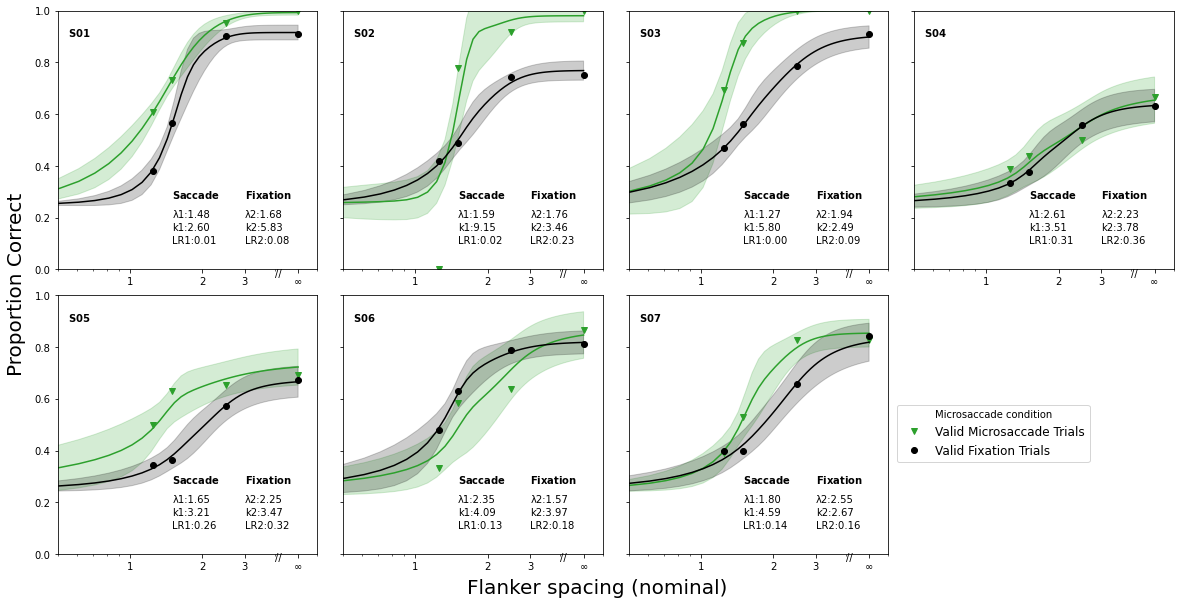

In [ ]:


bootstrap_fit=True
subs=behavData.subj_id.unique()
fig,ax=plt.subplots(nrows=2,ncols=4,sharey=True,figsize=(20,10))
subCounter=0
for row in ax:
    for col in row:
        if subCounter!=7:
            asub=subs[subCounter]
            # This plots the psychometric function in trials with and without microsaccades independently
            # Set whether or not to use bootstrap fit
            # First we declare the data/trials with congruent microsaccades
            dataWsacc=sacc200msOnsetDF.query("subj_id_x==@asub & trialValidity=='valid' & spacing!=1.2") # to fix cases where the rel onset time is really big
            #get samples
            x_all = dataWsacc['spacing'].unique()
            #     x_all.sort()
            y_all = dataWsacc.groupby('spacing')['corr'].mean().values
            x_sacc=x_all#[:-1]
            x_sacc.sort()
            y_sacc=y_all#[:-1]
            y_sacc.sort()

            # second we declare the data/trials without microsaccades
            dataWOsacc=behavDataNoMicrosaccade.query("subj_id==@asub & trialValidity=='valid' & spacing!=1.2") # to fix cases where the rel onset time is really big
            #get samples
            x_all = dataWOsacc['spacing'].unique()
            #     x_all.sort()
            y_all = dataWOsacc.groupby('spacing')['corr'].mean().values
            x_nosacc=x_all#[:-1]
            x_nosacc.sort()
            y_nosacc=y_all#[:-1]
            y_nosacc.sort()


            # REGRESSION ------------------------------------------------------------------
            p0 = [3.5, 2,0.05] #weibull                                       # guessed params
            #     p0=[-1.5,-1,1] # exponential
            w1, _ = opt.curve_fit(func_weibull, x_sacc, y_sacc, p0=p0)
            w2, _ = opt.curve_fit(func_weibull, x_nosacc, y_nosacc, p0=p0)
        #     print("Estimated Parameters:Saccade", w1)  
        #     print("Estimated Parameters:no saccade", w2)  

            unflanked_position=5
            # Model
            x_lin=np.linspace(0,unflanked_position,50) # we move the unflanked one to 6th pos to make it look nice
            y_model_sacc = func_weibull(x_lin, *w1)
            y_model_nosacc= func_weibull(x_lin, *w2)

            #plot congruent microsaccade condition
        #     sns.pointplot(data=dataWsacc,x='spacing',y='corr',join=False,ax=col,palette=['C2'])
            col.plot(x_sacc[:-1], y_sacc[:-1],ls='',marker='v',color='C2',label='Valid Microsaccade Trials')
            col.plot(unflanked_position,y_sacc[-1], marker='v',color='C2')

            if bootstrap_fit==True:
                sns.lineplot(x='x_lin',y='y_model',color='C2',ci='sd',data=y_model_df.query("microsaccade_condition=='saccade' & subj==@asub"),ax=col)
            else:
                col.plot(x_lin,y_model_sacc,ls='--',color='C2')
            #plot no saccade condtion
        #     sns.pointplot(data=dataWOsacc,x='spacing',y='corr',join=False,ax=col,palette=['k'])
            col.plot(x_nosacc[:-1], y_nosacc[:-1],ls='',marker='o',color='k',label='Valid Fixation Trials')
            col.plot(unflanked_position,y_nosacc[-1],marker='o',color='k')

            if bootstrap_fit==True:
                sns.lineplot(x='x_lin',y='y_model',color='k',ci='sd',data=y_model_df.query("microsaccade_condition=='no_saccade' & subj==@asub"),ax=col)
                col.set_xlabel('')
                col.set_ylabel('')
            else:
                col.plot(x_lin,y_model_nosacc,ls='--',color='k')
            #plot tweaks
            if subCounter==6:
                col.legend(title='Microsaccade condition',bbox_to_anchor=(1.8,0.6), prop={'size': 12})
            else:
                if bootstrap_fit==True:
                    col.get_legend().remove()
            col.set_ylim(0,1)
            col.set_xlim(0.5,6)
            col.set_xscale('log')
            col.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
            col.set_xticks([1,2,3,unflanked_position])
            col.set_xticklabels(['1','2','3','∞'])
            # We add the fit parameters inside the plot
            col.text(col.get_xlim()[0]+0.05,0.90,r"$\bf{%s}$"%asub)
            col.text(4,-0.025,'//')
            first_pos=1.5
            second_pos=3
            if bootstrap_fit==True:
                # we get the fit measures from the bootrapped DF
                w1=fit_paramsDF.query("saccade_cond=='saccade' & subj==@asub").mean()
                w2=fit_paramsDF.query("saccade_cond=='no_saccade' & subj==@asub").mean()
                col.text(first_pos,0.2,"λ1:%.2f"%w1[0])
                col.text(second_pos,0.2,"λ2:%.2f"%w2[0])
                col.text(first_pos,0.15,"k1:%.2f"%w1[1])
                col.text(second_pos,0.15,"k2:%.2f"%w2[1])
                col.text(first_pos,0.1,"LR1:%.2f"%w1[2])
                col.text(second_pos,0.1,"LR2:%.2f"%w2[2])
            else:
                col.text(first_pos,0.2,"λ1:%.2f"%w1[0])
                col.text(second_pos,0.2,"λ2:%.2f"%w2[0])
                col.text(first_pos,0.15,"k1:%.2f"%w1[1])
                col.text(second_pos,0.15,"k2:%.2f"%w2[1])
                col.text(first_pos,0.1,"LR1:%.2f"%w1[2])
                col.text(second_pos,0.1,"LR2:%.2f"%w2[2])
            col.text(first_pos,0.275,r"$\bf{Saccade}$")
            col.text(second_pos,0.275,r"$\bf{Fixation}$")
            subCounter+=1
        #     We compute critical spacings and mark them on the plot
        #     cs_sacc=(np.interp(0.75, y_model_sacc,x_lin))
        #     cs_nosacc=(np.interp(0.75, y_model_nosacc,x_lin))
        #     plt.hlines(y=0.75,xmin=0,xmax=cs_nosacc,color='k',linestyle='--',alpha=0.1)
        #     plt.axvline(x=cs_sacc,ymin=0,ymax=0.75,linestyle='--',color='C2')
        #     plt.axvline(x=cs_nosacc,ymin=0,ymax=0.75,linestyle='--',color='k')
        #     print("Incongruent:%.2f,Congruent:%.2f,NoSaccade:%.2f"%(cs_incong,cs_cong,cs_nosacc))
        #     col.set_xscale('log')
        else:
            fig.delaxes(col)
fig.text(0.09,0.5,"Proportion Correct",size=20,va='center',rotation=90)
fig.text(0.5,0.07,"Flanker spacing (nominal)",size=20,ha='center')
fig.subplots_adjust(wspace=0.1,hspace=0.1)
#fig.tight_layout()
if bootstrap_fit==True:
    plt.savefig('..\Plots\psychometricFunction_hue_microsaccadeCondition_bootstrap_fit_2by4.tiff',format='tiff',dpi=1200,bbox_inches='tight')
else:
    plt.savefig('..\Plots\psychometricFunction_hue_microsaccadeCondition_2by4.svg',format='svg',dpi=1200)

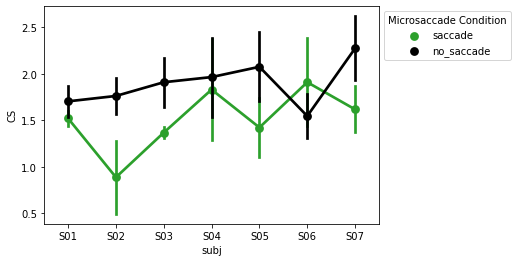

In [236]:
sns.pointplot(data=CS_df,x='subj',y='CS',hue='microsaccade_condition',ci='sd',palette=['C2','k'])
plt.legend(title='Microsaccade Condition',bbox_to_anchor=(1,1))

In [238]:
CS_df.groupby('microsaccade_condition')['CS'].describe()

count      mean       std       min       25%  \
microsaccade_condition                                                   
no_saccade              7000.0  1.889213  0.374612  0.081401  1.598106   
saccade                 7000.0  1.506889  0.467934  0.071171  1.339491   

                             50%       75%       max  
microsaccade_condition                                
no_saccade              1.857953  2.121502  3.448803  
saccade                 1.454799  1.713952  3.383538

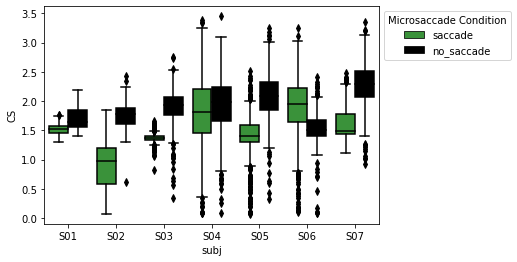

In [243]:
sns.boxplot(data=CS_df,x='subj',y='CS',hue='microsaccade_condition',palette=['C2','k'])
plt.legend(title='Microsaccade Condition',bbox_to_anchor=(1,1))

C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in power
C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in power
C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in power
C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in power
C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in power
C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in power


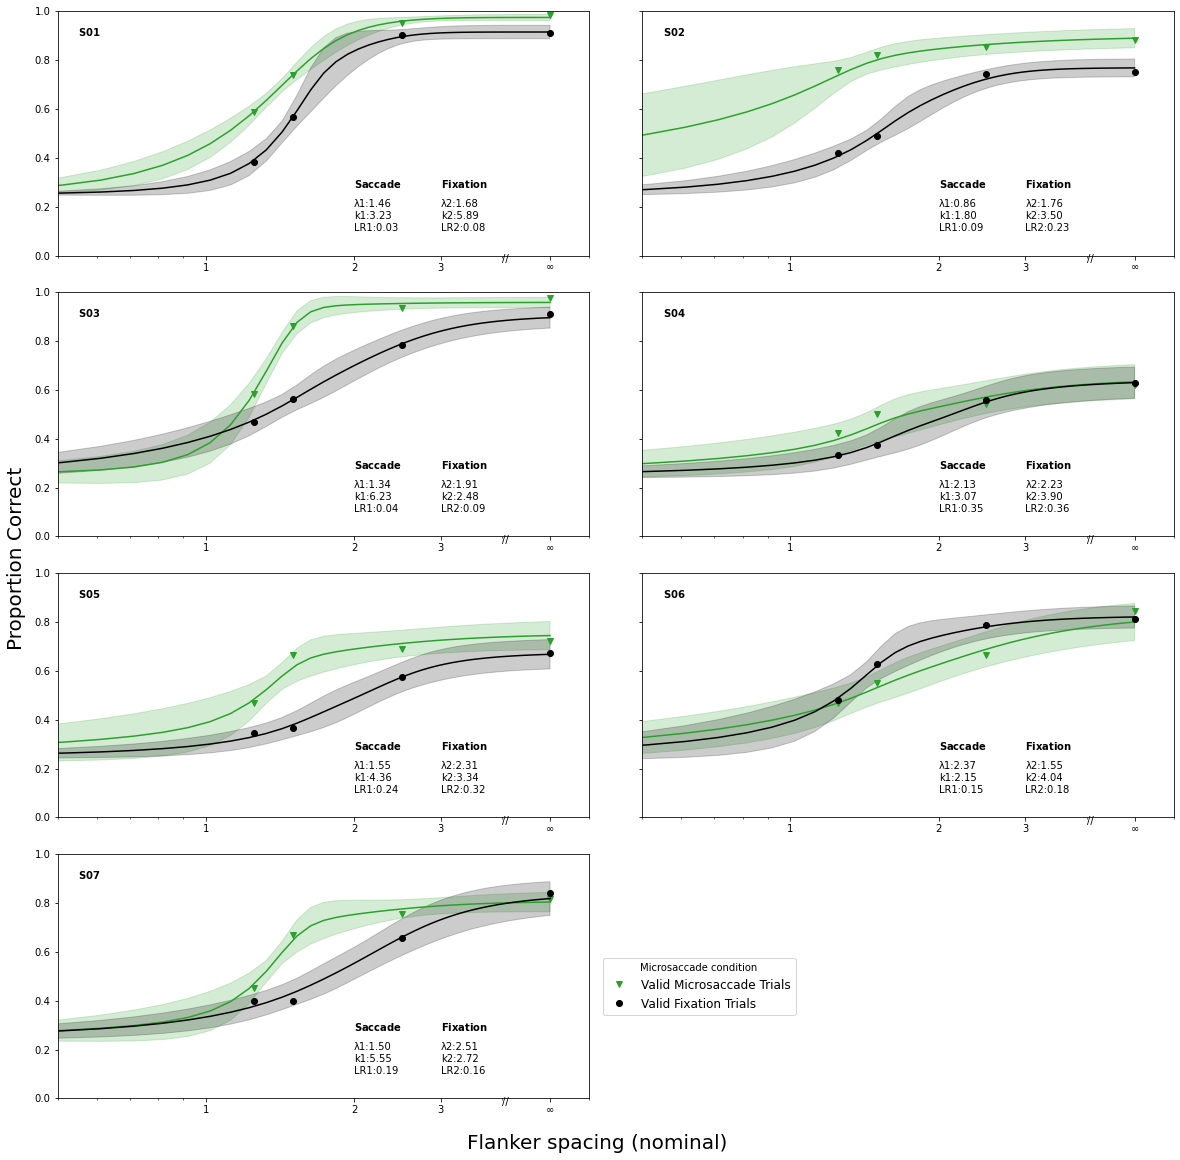

In [18]:


bootstrap_fit=True
subs=behavData.subj_id.unique()
fig,ax=plt.subplots(nrows=4,ncols=2,sharey=True,figsize=(20,20))
subCounter=0
for row in ax:
    for col in row:
        if subCounter!=7:
            asub=subs[subCounter]
            # This plots the psychometric function in trials with and without microsaccades independently
            # Set whether or not to use bootstrap fit
            # First we declare the data/trials with congruent microsaccades
            dataWsacc=sacc200msOnsetDF.query("subj_id_x==@asub & trialValidity=='valid' & spacing!=1.2") # to fix cases where the rel onset time is really big
            #get samples
            x_all = dataWsacc['spacing'].unique()
            #     x_all.sort()
            y_all = dataWsacc.groupby('spacing')['corr'].mean().values
            x_sacc=x_all#[:-1]
            x_sacc.sort()
            y_sacc=y_all#[:-1]
            y_sacc.sort()

            # second we declare the data/trials without microsaccades
            dataWOsacc=behavDataNoMicrosaccade.query("subj_id==@asub & trialValidity=='valid' & spacing!=1.2") # to fix cases where the rel onset time is really big
            #get samples
            x_all = dataWOsacc['spacing'].unique()
            #     x_all.sort()
            y_all = dataWOsacc.groupby('spacing')['corr'].mean().values
            x_nosacc=x_all#[:-1]
            x_nosacc.sort()
            y_nosacc=y_all#[:-1]
            y_nosacc.sort()


            # REGRESSION ------------------------------------------------------------------
            p0 = [3.5, 2,0.05] #weibull                                       # guessed params
            #     p0=[-1.5,-1,1] # exponential
            w1, _ = opt.curve_fit(func_weibull, x_sacc, y_sacc, p0=p0)
            w2, _ = opt.curve_fit(func_weibull, x_nosacc, y_nosacc, p0=p0)
        #     print("Estimated Parameters:Saccade", w1)  
        #     print("Estimated Parameters:no saccade", w2)  

            unflanked_position=5
            # Model
            x_lin=np.linspace(0,unflanked_position,50) # we move the unflanked one to 6th pos to make it look nice
            y_model_sacc = func_weibull(x_lin, *w1)
            y_model_nosacc= func_weibull(x_lin, *w2)

            #plot congruent microsaccade condition
        #     sns.pointplot(data=dataWsacc,x='spacing',y='corr',join=False,ax=col,palette=['C2'])
            col.plot(x_sacc[:-1], y_sacc[:-1],ls='',marker='v',color='C2',label='Valid Microsaccade Trials')
            col.plot(unflanked_position,y_sacc[-1], marker='v',color='C2')

            if bootstrap_fit==True:
                sns.lineplot(x='x_lin',y='y_model',color='C2',ci='sd',data=y_model_df.query("microsaccade_condition=='saccade' & subj==@asub"),ax=col)
            else:
                col.plot(x_lin,y_model_sacc,ls='--',color='C2')
            #plot no saccade condtion
        #     sns.pointplot(data=dataWOsacc,x='spacing',y='corr',join=False,ax=col,palette=['k'])
            col.plot(x_nosacc[:-1], y_nosacc[:-1],ls='',marker='o',color='k',label='Valid Fixation Trials')
            col.plot(unflanked_position,y_nosacc[-1],marker='o',color='k')

            if bootstrap_fit==True:
                sns.lineplot(x='x_lin',y='y_model',color='k',ci='sd',data=y_model_df.query("microsaccade_condition=='no_saccade' & subj==@asub"),ax=col)
                col.set_xlabel('')
                col.set_ylabel('')
            else:
                col.plot(x_lin,y_model_nosacc,ls='--',color='k')
            #plot tweaks
            if subCounter==6:
                col.legend(title='Microsaccade condition',bbox_to_anchor=(1.4,0.6), prop={'size': 12})
            else:
                if bootstrap_fit==True:
                    col.get_legend().remove()
            col.set_ylim(0,1)
            col.set_xlim(0.5,6)
            col.set_xscale('log')
            col.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
            col.set_xticks([1,2,3,unflanked_position])
            col.set_xticklabels(['1','2','3','∞'])
            # We add the fit parameters inside the plot
            col.text(col.get_xlim()[0]+0.05,0.90,r"$\bf{%s}$"%asub)
            col.text(4,-0.025,'//')
            first_pos=2
            second_pos=3
            if bootstrap_fit==True:
                # we get the fit measures from the bootrapped DF
                w1=fit_paramsDF.query("saccade_cond=='saccade' & subj==@asub").mean()
                w2=fit_paramsDF.query("saccade_cond=='no_saccade' & subj==@asub").mean()
                col.text(first_pos,0.2,"λ1:%.2f"%w1[1])
                col.text(second_pos,0.2,"λ2:%.2f"%w2[1])
                col.text(first_pos,0.15,"k1:%.2f"%w1[2])
                col.text(second_pos,0.15,"k2:%.2f"%w2[2])
                col.text(first_pos,0.1,"LR1:%.2f"%w1[3])
                col.text(second_pos,0.1,"LR2:%.2f"%w2[3])
            else:
                col.text(first_pos,0.2,"λ1:%.2f"%w1[0])
                col.text(second_pos,0.2,"λ2:%.2f"%w2[0])
                col.text(first_pos,0.15,"k1:%.2f"%w1[1])
                col.text(second_pos,0.15,"k2:%.2f"%w2[1])
                col.text(first_pos,0.1,"LR1:%.2f"%w1[2])
                col.text(second_pos,0.1,"LR2:%.2f"%w2[2])
            col.text(first_pos,0.275,r"$\bf{Saccade}$")
            col.text(second_pos,0.275,r"$\bf{Fixation}$")
            subCounter+=1
        #     We compute critical spacings and mark them on the plot
        #     cs_sacc=(np.interp(0.75, y_model_sacc,x_lin))
        #     cs_nosacc=(np.interp(0.75, y_model_nosacc,x_lin))
        #     plt.hlines(y=0.75,xmin=0,xmax=cs_nosacc,color='k',linestyle='--',alpha=0.1)
        #     plt.axvline(x=cs_sacc,ymin=0,ymax=0.75,linestyle='--',color='C2')
        #     plt.axvline(x=cs_nosacc,ymin=0,ymax=0.75,linestyle='--',color='k')
        #     print("Incongruent:%.2f,Congruent:%.2f,NoSaccade:%.2f"%(cs_incong,cs_cong,cs_nosacc))
        #     col.set_xscale('log')
        else:
            fig.delaxes(col)
fig.text(0.09,0.5,"Proportion Correct",size=20,va='center',rotation=90)
fig.text(0.5,0.09,"Flanker spacing (nominal)",size=20,ha='center')
fig.subplots_adjust(wspace=0.1,hspace=0.15)
#fig.tight_layout()
if bootstrap_fit==True:
    plt.savefig('..\Plots\psychometricFunction_hue_microsaccadeCondition_bootstrap_fit.svg',format='svg',dpi=1200)
else:
    plt.savefig('..\Plots\psychometricFunction_hue_microsaccadeCondition.svg',format='svg',dpi=1200)

c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in power
c:\Users\krish\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in power
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in power
c:\Users\krish\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in power
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in power
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_

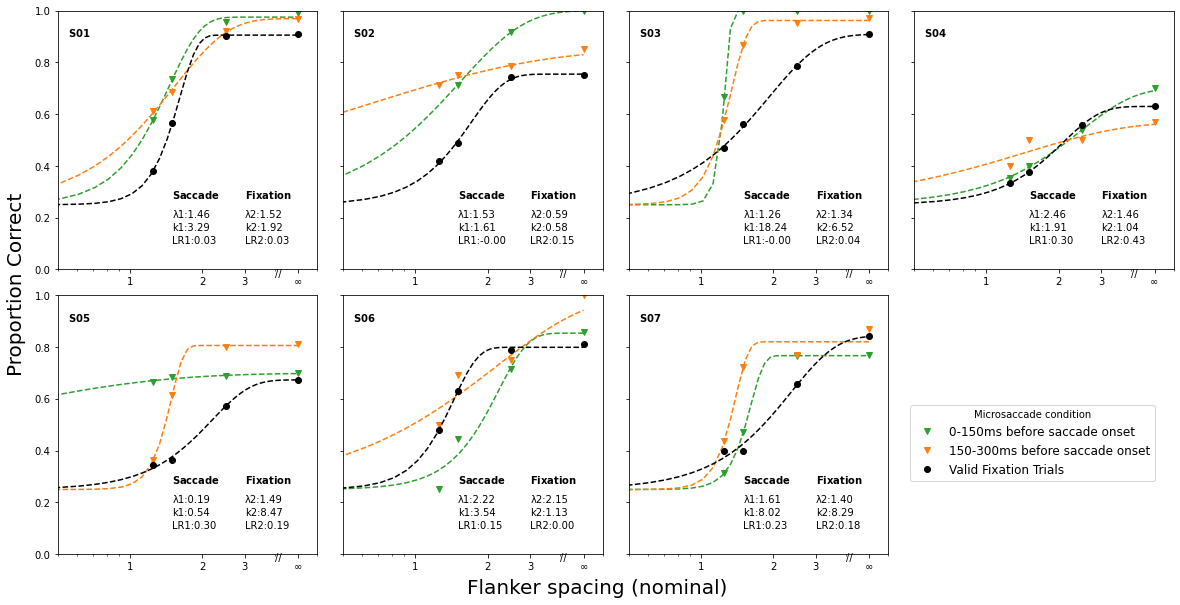

In [14]:
## We subdivide saccade trials into ones with stimuli 0-150 ms and 150-300 ms before saccade onset  
sacc0to150ms=sacc200msOnsetDF.query("-0.150<relStimTime<0")
sacc150to300ms=sacc200msOnsetDF.query("-0.300<relStimTime<-0.150")

bootstrap_fit=False
subs=behavData.subj_id.unique()
fig,ax=plt.subplots(nrows=2,ncols=4,sharey=True,figsize=(20,10))
subCounter=0
for row in ax:
    for col in row:
        if subCounter!=7:
            asub=subs[subCounter]
            # This plots the psychometric function in trials with and without microsaccades independently
            # Set whether or not to use bootstrap fit
            # First we declare the data/trials with congruent microsaccades
            dataWsacc0to150ms=sacc0to150ms.query("subj_id_x==@asub & trialValidity=='valid' & spacing!=1.2") # to fix cases where the rel onset time is really big
            #get samples
            x_all = dataWsacc0to150ms['spacing'].unique()
            #     x_all.sort()
            y_all = dataWsacc0to150ms.groupby('spacing')['corr'].mean().values
            x_sacc0to150ms=x_all#[:-1]
            x_sacc0to150ms.sort()
            y_sacc0to150ms=y_all#[:-1]
            y_sacc0to150ms.sort()

            # First we declare the data/trials with congruent microsaccades
            dataWsacc150to300ms=sacc150to300ms.query("subj_id_x==@asub & trialValidity=='valid' & spacing!=1.2") # to fix cases where the rel onset time is really big
            #get samples
            x_all = dataWsacc150to300ms['spacing'].unique()
            #     x_all.sort()
            y_all = dataWsacc150to300ms.groupby('spacing')['corr'].mean().values
            x_sacc150to300ms=x_all#[:-1]
            x_sacc150to300ms.sort()
            y_sacc150to300ms=y_all#[:-1]
            y_sacc150to300ms.sort()

            # second we declare the data/trials without microsaccades
            dataWOsacc=behavDataNoMicrosaccade.query("subj_id==@asub & trialValidity=='valid' & spacing!=1.2") # to fix cases where the rel onset time is really big
            #get samples
            x_all = dataWOsacc['spacing'].unique()
            #     x_all.sort()
            y_all = dataWOsacc.groupby('spacing')['corr'].mean().values
            x_nosacc=x_all#[:-1]
            x_nosacc.sort()
            y_nosacc=y_all#[:-1]
            y_nosacc.sort()


            # REGRESSION ------------------------------------------------------------------
            p0 = [3.5, 2,0.05] #weibull                                       # guessed params
            #     p0=[-1.5,-1,1] # exponential
            w1, _ = opt.curve_fit(func_weibull, x_sacc0to150ms, y_sacc0to150ms, p0=p0)
            w2, _=opt.curve_fit(func_weibull, x_sacc150to300ms, y_sacc150to300ms, p0=p0)
            w3, _ = opt.curve_fit(func_weibull, x_nosacc, y_nosacc, p0=p0)
        #     print("Estimated Parameters:Saccade", w1)  
        #     print("Estimated Parameters:no saccade", w2)  

            unflanked_position=5
            # Model
            x_lin=np.linspace(0,unflanked_position,50) # we move the unflanked one to 6th pos to make it look nice
            y_model_sacc0to150ms = func_weibull(x_lin, *w1)
            y_model_sacc150to300ms=func_weibull(x_lin, *w2)
            y_model_nosacc= func_weibull(x_lin, *w3)

            #plot early microsaccade condition
        #     sns.pointplot(data=dataWsacc,x='spacing',y='corr',join=False,ax=col,palette=['C2'])
            col.plot(x_sacc0to150ms[:-1], y_sacc0to150ms[:-1],ls='',marker='v',color='C2',label='0-150ms before saccade onset')
            col.plot(unflanked_position,y_sacc0to150ms[-1], marker='v',color='C2')

            if bootstrap_fit==True:
                sns.lineplot(x='x_lin',y='y_model',color='C2',ci='sd',data=y_model_df.query("microsaccade_condition=='saccade' & subj==@asub"),ax=col)
            else:
                col.plot(x_lin,y_model_sacc0to150ms,ls='--',color='C2')

            # plot intermediate microsaccade condition
            col.plot(x_sacc150to300ms[:-1], y_sacc150to300ms[:-1],ls='',marker='v',color='C1',label='150-300ms before saccade onset')
            col.plot(unflanked_position,y_sacc150to300ms[-1], marker='v',color='C1')

            if bootstrap_fit==True:
                sns.lineplot(x='x_lin',y='y_model',color='C1',ci='sd',data=y_model_df.query("microsaccade_condition=='saccade' & subj==@asub"),ax=col)
            else:
                col.plot(x_lin,y_model_sacc150to300ms,ls='--',color='C1')
            #plot no saccade condtion
        #     sns.pointplot(data=dataWOsacc,x='spacing',y='corr',join=False,ax=col,palette=['k'])
            col.plot(x_nosacc[:-1], y_nosacc[:-1],ls='',marker='o',color='k',label='Valid Fixation Trials')
            col.plot(unflanked_position,y_nosacc[-1],marker='o',color='k')

            if bootstrap_fit==True:
                sns.lineplot(x='x_lin',y='y_model',color='k',ci='sd',data=y_model_df.query("microsaccade_condition=='no_saccade' & subj==@asub"),ax=col)
                col.set_xlabel('')
                col.set_ylabel('')
            else:
                col.plot(x_lin,y_model_nosacc,ls='--',color='k')
            #plot tweaks
            if subCounter==6:
                col.legend(title='Microsaccade condition',bbox_to_anchor=(2.05,0.6), prop={'size': 12})
            else:
                if bootstrap_fit==True:
                    col.get_legend().remove()
            col.set_ylim(0,1)
            col.set_xlim(0.5,6)
            col.set_xscale('log')
            col.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
            col.set_xticks([1,2,3,unflanked_position])
            col.set_xticklabels(['1','2','3','∞'])
            # We add the fit parameters inside the plot
            col.text(col.get_xlim()[0]+0.05,0.90,r"$\bf{%s}$"%asub)
            col.text(4,-0.025,'//')
            first_pos=1.5
            second_pos=3
            if bootstrap_fit==True:
                # we get the fit measures from the bootrapped DF
                w1=fit_paramsDF.query("saccade_cond=='saccade' & subj==@asub").mean()
                w2=fit_paramsDF.query("saccade_cond=='no_saccade' & subj==@asub").mean()
                col.text(first_pos,0.2,"λ1:%.2f"%w1[0])
                col.text(second_pos,0.2,"λ2:%.2f"%w2[0])
                col.text(first_pos,0.15,"k1:%.2f"%w1[1])
                col.text(second_pos,0.15,"k2:%.2f"%w2[1])
                col.text(first_pos,0.1,"LR1:%.2f"%w1[2])
                col.text(second_pos,0.1,"LR2:%.2f"%w2[2])
            else:
                col.text(first_pos,0.2,"λ1:%.2f"%w1[0])
                col.text(second_pos,0.2,"λ2:%.2f"%w2[0])
                col.text(first_pos,0.15,"k1:%.2f"%w1[1])
                col.text(second_pos,0.15,"k2:%.2f"%w2[1])
                col.text(first_pos,0.1,"LR1:%.2f"%w1[2])
                col.text(second_pos,0.1,"LR2:%.2f"%w2[2])
            col.text(first_pos,0.275,r"$\bf{Saccade}$")
            col.text(second_pos,0.275,r"$\bf{Fixation}$")
            subCounter+=1
        else:
            fig.delaxes(col)
fig.text(0.09,0.5,"Proportion Correct",size=20,va='center',rotation=90)
fig.text(0.5,0.07,"Flanker spacing (nominal)",size=20,ha='center')
fig.subplots_adjust(wspace=0.1,hspace=0.1)
#fig.tight_layout()
# if bootstrap_fit==True:
#     plt.savefig('..\Plots\psychometricFunction_hue_microsaccadeCondition_bootstrap_fit_2by4.svg',format='svg',dpi=1200)
# else:
#     plt.savefig('..\Plots\psychometricFunction_hue_microsaccadeCondition_2by4.svg',format='svg',dpi=1200)

[Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3'), Text(5, 0, '∞')]

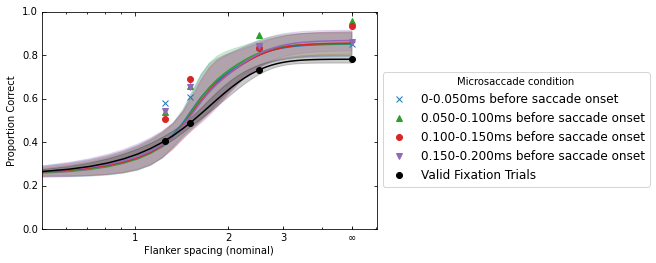

In [435]:
## We subdivide saccade trials into ones with stimuli 0-150 ms and 150-300 ms before saccade onset  
bootstrap_fit=True

startTimeStamp=[0,-0.050,-0.100,-0.150]
endTimeStamp=[-0.050,-0.100,-0.150,-0.200]


fig=plt.figure()
 
ax = Subplot(fig, 111)
fig.add_subplot(ax)

num_steps=len(startTimeStamp)
for i in range(num_steps):
    startTime=startTimeStamp[i]
    endTime=endTimeStamp[i]
    # we filter saccade data
    saccDF_timeFiltered=sacc200msOnsetDF.query("@endTime<relStimTime<@startTime & spacing!=1.2")

    # We set color, marker & label based on condition
    if i==0:
        colorType='C0'
        markerLabel='%d-%.3fms before saccade onset'%(startTime,endTime*-1)
        markerType='x'
    elif i==1:
        colorType='C2'
        markerLabel='%.3f-%.3fms before saccade onset'%(startTime*-1,endTime*-1)
        markerType='^'
    elif i==2:
        colorType='C3'
        markerLabel='%.3f-%.3fms before saccade onset'%(startTime*-1,endTime*-1)
        markerType='o'
    elif i==3:
        colorType='C4'
        markerLabel='%.3f-%.3fms before saccade onset'%(startTime*-1,endTime*-1)
        markerType='v'
    elif i==4:
        colorType='C5'
        markerLabel='%.3f-%.3fms before saccade onset'%(startTime*-1,endTime*-1)
        markerType='+'
    
    # This plots the psychometric function in trials with and without microsaccades independently
    # Set whether or not to use bootstrap fit
    # First we declare the data/trials with congruent microsaccades
    dataWSacc=saccDF_timeFiltered # to fix cases where the rel onset time is really big
    #get samples
    x_all = dataWSacc['spacing'].unique()
    #     x_all.sort()
    y_all = dataWSacc.groupby('spacing')['corr'].mean().values
    x_sacc=x_all#[:-1]
    x_sacc.sort()
    y_sacc=y_all#[:-1]
    y_sacc.sort()
    if bootstrap_fit==True:
        # We use bootstrapping procedure for each getting the fit for each resampled data 
        y_model_sacc_list=np.array([])
        x_lin_list=np.array([])
        for resample_idx in range(100):
            #1. Resample DF
            new_df_sacc = dataWsacc.sample(n=len(dataWsacc),replace=True)
            # Model
            unflanked_position=5
            x_lin=np.linspace(0,unflanked_position,50)
            w1,y_model_sacc,CS_sacc,fifty_percent_interp_sacc = fit_and_get_CS(new_df_sacc,x_lin)

            # Finally we save it to a DF
            y_model_sacc_list=np.concatenate((y_model_sacc_list,y_model_sacc),axis=None)
            x_lin_list=np.concatenate((x_lin_list,x_lin),axis=None)
        y_model_df_sacc=pd.DataFrame((np.column_stack((x_lin_list,y_model_sacc_list))),columns=['x_lin','y_model'])
        y_model_df_sacc['x_lin']=y_model_df_sacc['x_lin'].astype('float')
        y_model_df_sacc['y_model']=y_model_df_sacc['y_model'].astype('float')


    # second we declare the data/trials without microsaccades
    if i==num_steps-1:
        dataWOsacc=behavDataNoMicrosaccade.query("spacing!=1.2") # to fix cases where the rel onset time is really big
        #get samples
        x_all = dataWOsacc['spacing'].unique()
        #     x_all.sort()
        y_all = dataWOsacc.groupby('spacing')['corr'].mean().values
        x_nosacc=x_all#[:-1]
        x_nosacc.sort()
        y_nosacc=y_all#[:-1]
        y_nosacc.sort()
        if bootstrap_fit==True:
            y_model_nosacc_list=np.array([])
            x_lin_list=np.array([])
            for resample_idx in range(100):
                #1. Resample DF
                new_df_nosacc=dataWOsacc.sample(n=len(dataWOsacc),replace=True)
                # Model
                unflanked_position=5
                x_lin=np.linspace(0,unflanked_position,50)
                w2,y_model_nosacc,CS_nosacc,fifty_percent_interp_nosacc=fit_and_get_CS(new_df_nosacc,x_lin)

                # Finally we save it to a DF
                y_model_nosacc_list=np.concatenate((y_model_nosacc_list,y_model_nosacc),axis=None)
                x_lin_list=np.concatenate((x_lin_list,x_lin),axis=None)
            y_model_df_nosacc=pd.DataFrame((np.column_stack((x_lin_list,y_model_nosacc_list))),columns=['x_lin','y_model'])
            y_model_df_nosacc['x_lin']=y_model_df_nosacc['x_lin'].astype('float')
            y_model_df_nosacc['y_model']=y_model_df_nosacc['y_model'].astype('float')
    # REGRESSION ------------------------------------------------------------------
    if bootstrap_fit==False:
        p0 = [3.5, 2,0.05] #weibull                                       # guessed params
        #     p0=[-1.5,-1,1] # exponential
        w1, _ = opt.curve_fit(func_weibull, x_sacc, y_sacc, p0=p0)
    if i==num_steps-1:
        w2, _ = opt.curve_fit(func_weibull, x_nosacc, y_nosacc, p0=p0)
    #     print("Estimated Parameters:Saccade", w1)  
    #     print("Estimated Parameters:no saccade", w2)  

    unflanked_position=5
    # Model
    x_lin=np.linspace(0,unflanked_position,50) # we move the unflanked one to 6th pos to make it look nice
    if bootstrap_fit==False:
        y_model_sacc = func_weibull(x_lin, *w1)
        if i==num_steps-1:
            y_model_nosacc= func_weibull(x_lin, *w2)

    #plot early microsaccade condition
    ax.plot(x_sacc[:-1], y_sacc[:-1],ls='',marker=markerType,color=colorType,label=markerLabel)
    ax.plot(unflanked_position,y_sacc[-1], marker=markerType,color=colorType)

    if bootstrap_fit==True:
        sns.lineplot(x='x_lin',y='y_model',color=colorType,ci='sd',data=y_model_df_sacc)
    else:
        ax.plot(x_lin,y_model_sacc,ls='--',color=colorType)

    #plot no saccade condtion
    if i==num_steps-1:
        ax.plot(x_nosacc[:-1], y_nosacc[:-1],ls='',marker='o',color='k',label='Valid Fixation Trials')
        ax.plot(unflanked_position,y_nosacc[-1],marker='o',color='k')

        if bootstrap_fit==True:
            sns.lineplot(x='x_lin',y='y_model',color='k',ci='sd',data=y_model_df_nosacc)
            ax.set_xlabel('')
            ax.set_ylabel('')
        else:
            ax.plot(x_lin,y_model_nosacc,ls='--',color='k')
        #plot tweaks
    ax.legend(title='Microsaccade condition',bbox_to_anchor=(1,0.75), prop={'size': 12})

ax.set_ylim(0,1)
ax.set_xlim(0.5,6)
ax.set_xscale('log')
ax.set_ylabel("Proportion Correct",size=12)
ax.set_xlabel("Flanker spacing (nominal)",size=12)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks([1,2,3,unflanked_position])
ax.set_xticklabels(['1','2','3','∞'])

#fig.tight_layout()
# if bootstrap_fit==True:
#     plt.savefig('..\Plots\psychometricFunction_hue_TemporalProfileMicrosaccade.tiff',dpi=1200,bbox_inches='tight')
# else:
#     plt.savefig('..\Plots\psychometricFunction_hue_TemporalProfileMicrosaccade.tiff',format='tiff',dpi=1200,bbox_inches='tight')

## Z Score V Spacing Plots

In [154]:
###### subs=behavData.subj_id.unique()
spacing_list=[  1.5 ,   1.25,   2.5 , 100.]
trialcond_list=behavDataNoMicrosaccade.trialValidity.unique()
zScore_sacc=[]
zScore_noSacc=[]
total_iter=len(spacing_list) * 7 * 2
counter=1
for asub in subs:
    for aspacing in spacing_list:
        for trialCond in trialcond_list:
            print("%d/%d"%(counter,total_iter),end='\r')
            #No Saccade Trials
            data_nosacc=behavDataNoMicrosaccade.query("subj_id==@asub & trialValidity==@trialCond & spacing==@aspacing")['corr']
            propVals=bootstrap_corr_to_propCor(data_nosacc)
            zScores=bootstrap_corr_to_z(data_nosacc)
            tempDF_nosacc=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
            tempDF_nosacc['subj']=asub
            tempDF_nosacc['spacing']=aspacing
            tempDF_nosacc['trialValidity']=trialCond
            zScore_noSacc.append(tempDF_nosacc)
            #Saccade Trials
            data_sacc=sacc200msOnsetDF.query("subj_id_x==@asub & trialValidity==@trialCond & spacing==@aspacing")['corr']
            propVals=bootstrap_corr_to_propCor(data_sacc)
            zScores=bootstrap_corr_to_z(data_sacc)
            tempDF_sacc=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
            tempDF_sacc['subj']=asub
            tempDF_sacc['spacing']=aspacing
            tempDF_sacc['trialValidity']=trialCond
            zScore_sacc.append(tempDF_sacc)
            counter+=1
zScore_sacc=pd.concat(zScore_sacc)
zScore_noSacc=pd.concat(zScore_noSacc)

In [155]:
zScore_sacc.to_csv("zScore_sacc.csv")
zScore_noSacc.to_csv("ZScore_nosacc.csv")

c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_tight" which is no longer supported as of 3.3 and will become an error two minor releases later


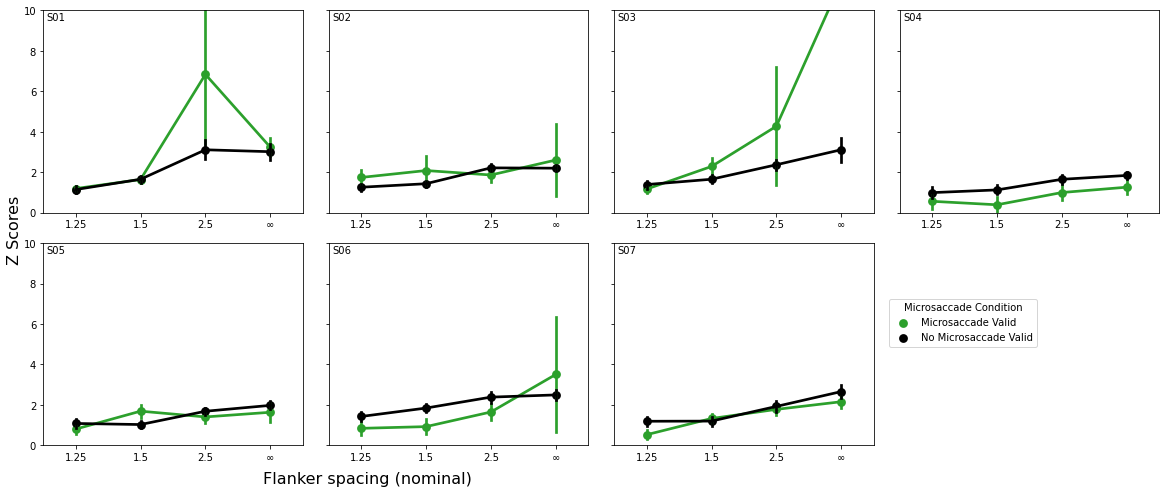

In [157]:
subs=behavData.subj_id.unique()
fig,axs=plt.subplots(2,4,figsize=(20,8),sharey=True)
subCounter=0
for row in axs:
    for col in row:
        if subCounter!=7:
            asub=subs[subCounter]
            sns.pointplot(data=zScore_sacc.query("subj==@asub and trialValidity=='valid'"),hue='trialValidity',x='spacing',y='zScores',palette=['C2'],ci='sd',ax=col)
            sns.pointplot(data=zScore_nosacc.query("subj==@asub and trialValidity=='valid'"),hue='trialValidity',x='spacing',y='zScores',ci='sd',ax=col,palette=['k'])
            leg_handles = col.get_legend_handles_labels()[0]
            if subCounter==6:
                col.legend(leg_handles, ['Microsaccade Valid','No Microsaccade Valid'], title='Microsaccade Condition',bbox_to_anchor=(1.65,0.75))
            else:
                col.get_legend().remove()
            col.yaxis.label.set_visible(False)
            col.xaxis.label.set_visible(False)
            col.set_ylim(0,10)
            col.text(col.get_xlim()[0]+0.05,col.get_ylim()[1]-0.5,asub)
            #col.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
            col.set_xticks([0,1,2,3])
            col.set_xticklabels(['1.25','1.5','2.5','∞'])
            #col.grid()
            subCounter+=1
        else:
            fig.delaxes(col)
fig.text(0.1,0.5,"Z Scores",size=16,va='center',rotation=90)
fig.text(0.35,0.06,"Flanker spacing (nominal)",size=16,ha='center')   
fig.subplots_adjust(wspace=0.1,hspace=0.15)
# fig.tight_layout()
plt.savefig("..\Plots\ZScoreVspacing_bySubj.pdf",dpi=1200,bbox_tight='inches')

## Binned Performance Data

In [85]:
# Microsaccade metrics binned with respect to stimulus onset

# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.050 #seconds
binSize=0.100

startPt=-0.250
endPt=0.050
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
subs=sacc200msOnsetDF.subj_id_x.unique()
numelements=len(subs)*len(bins)
counter=1
# we create the necessary lists
# first we create lists for the experiment conditions
# First for the performance df
# No microsaccade condition list
BinDataPerf_sacc=[]
BinDataPerf_nosacc=[]
for asub in subs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        # Trials with microsaccades present
        print('%d/%d'%(counter,numelements),end='\r')
        perfDF=sacc200msOnsetDF.query("@start<relStimTime<@end & subj_id_x==@asub").drop_duplicates(subset=['code'])
        perfDF['binPt']=abin
        BinDataPerf_sacc.append(perfDF)
        counter+=1
    #Trials W/o microsaccades 
    datanoSacc=behavDataNoMicrosaccade.query("subj_id==@asub")
    BinDataPerf_nosacc.append(datanoSacc)
                    
BinDataPerf_sacc=pd.concat(BinDataPerf_sacc)
BinDataPerf_nosacc=pd.concat(BinDataPerf_nosacc)

In [86]:
#### Equal bin width method: \n",
# Cons: Every bin would have different number of samples/trials\n",
#segregate by spacing\n",
startPt=-0.400
stepSize=0.050#0.025
binSize=0.125
endPt=0.025
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
subs=saccadeData['subj_id_x'].unique()
spacings=[  1.25,   2.5 ,   1.5 , 100.]
nums=saccadeData['target'].unique()
counter=1
total_iter=len(bins)*len(subs)*len(spacings)
#second we create lists for the outcome/microsaccade metrics
binSacc_subj=[]
for abin in bins:
    start=abin-binWidth
    end=abin+binWidth
    for aspacing in spacings:
        for asub in subs:
            print("%d/%d"%(counter,total_iter),end='\r')
            data=saccadeData.query("@start<relStimTime<@end & spacing==@aspacing  & subj_id_x==@asub & trialValidity=='valid'")['corr']
            # we get bootstrapped proportion correct from response values and create a df
            propVals=bootstrap_corr_to_propCor(data)
            zScores=bootstrap_corr_to_z(data)
            tempDF=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
            tempDF['binPt']=abin
            tempDF['subj']=asub
            tempDF['spacing']=aspacing
            binSacc_subj.append(tempDF)
            counter+=1                                        
binSacc_subj=pd.concat(binSacc_subj)

#Do the same thing for the fixation condition
counter=1
total_iter=len(subs)*len(spacings)
# create an empty list for fixation condition
binFix_subj=[]
for asub in subs:
    for aspacing in spacings:
        print("%d/%d"%(counter,total_iter),end='\r')
        data=behavDataNoMicrosaccade.query("spacing==@aspacing  & subj_id==@asub & trialValidity=='valid'")['corr']
        # we get bootstrapped proportion correct from response values and create a df
        propVals=bootstrap_corr_to_propCor(data)
        zScores=bootstrap_corr_to_z(data)
        tempDF=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
        tempDF['subj']=asub
        tempDF['spacing']=aspacing
        binFix_subj.append(tempDF)
        counter+=1
            
binFix_subj=pd.concat(binFix_subj)
# add a column that would used for plotting
binFix_subj['binPt']=-0.200

In [87]:
# Percent enhancement computation
startPt=-0.400
stepSize=0.050#0.025
binSize=0.125
endPt=0.025
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
subs=saccadeData['subj_id_x'].unique()
spacings=[  1.25,   2.5 ,   1.5 , 100.]
nums=saccadeData['target'].unique()
counter=1
total_iter=len(bins)*len(subs)*len(spacings)
#second we create lists for the outcome/microsaccade metrics
binImprovement_subj=[]
for abin in bins:
    start=abin-binWidth
    end=abin+binWidth
    for aspacing in spacings:
        for asub in subs:
            print("%d/%d"%(counter,total_iter),end='\r')
            data=saccadeData.query("@start<relStimTime<@end & spacing==@aspacing  & subj_id_x==@asub")['corr']
            # Fixation Data
            FixData=binFix_subj.query("spacing==@aspacing and subj==@asub")['propCorr']
            FixData_zScores=bootstrap_corr_to_z(FixData)
            # we get bootstrapped proportion correct from response values and create a df
            propVals=bootstrap_corr_to_propCor(data)
            zScores=bootstrap_corr_to_z(data)
            # We subtract mean from no microsaccade condition
            propVals_improvement=[aVal - FixData.mean() for aVal in propVals]
            zScores_improvement=[aVal - np.mean(FixData_zScores) for aVal in zScores ]
            tempDF=pd.DataFrame(np.column_stack((propVals_improvement,zScores_improvement)),columns=['propCorr','zScores'])
            tempDF['binPt']=abin
            tempDF['subj']=asub
            tempDF['spacing']=aspacing
            binImprovement_subj.append(tempDF)
            counter+=1                                        
binImprovement_subj=pd.concat(binImprovement_subj)

In [ ]:
g=sns.FacetGrid(size=4, aspect=1, col="spacing",row='subj',
               data=binImprovement_subj)
g.map(sns.lineplot,'binPt','propCorr',ci="sd",color='C1',label='Microsaccade',marker='o')
axes=g.fig.axes
for ax in axes:
    # Add a vertical line to represent saccade onset
    ax.vlines(ymin=-0.4,ymax=1,x=0,color='k',linestyle='--')
    # Horizontal line for no improvement
    ax.hlines(xmin=-0.4,xmax=0,y=0,color='k',linestyle='--')

In [ ]:
g=sns.FacetGrid(size=4, aspect=1, col="spacing",row='subj',
               data=binImprovement_subj)
g.map(sns.lineplot,'binPt','zScores',ci="sd",color='C1',label='Microsaccade',marker='o')
axes=g.fig.axes
for ax in axes:
    plt.ylim(-2,2)
    # Add a vertical line to represent saccade onset
    ax.vlines(ymin=-4,ymax=10,x=0,color='k',linestyle='--')
    # Horizontal line for no improvement
    ax.hlines(xmin=-0.4,xmax=0,y=0,color='k',linestyle='--')

In [ ]:
BinDataPerf_nosacc.query("spacing==@aspacing & subj_id==@asub")['corr'].mean()#.reset_index()

c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_tight" which is no longer supported as of 3.3 and will become an error two minor releases later


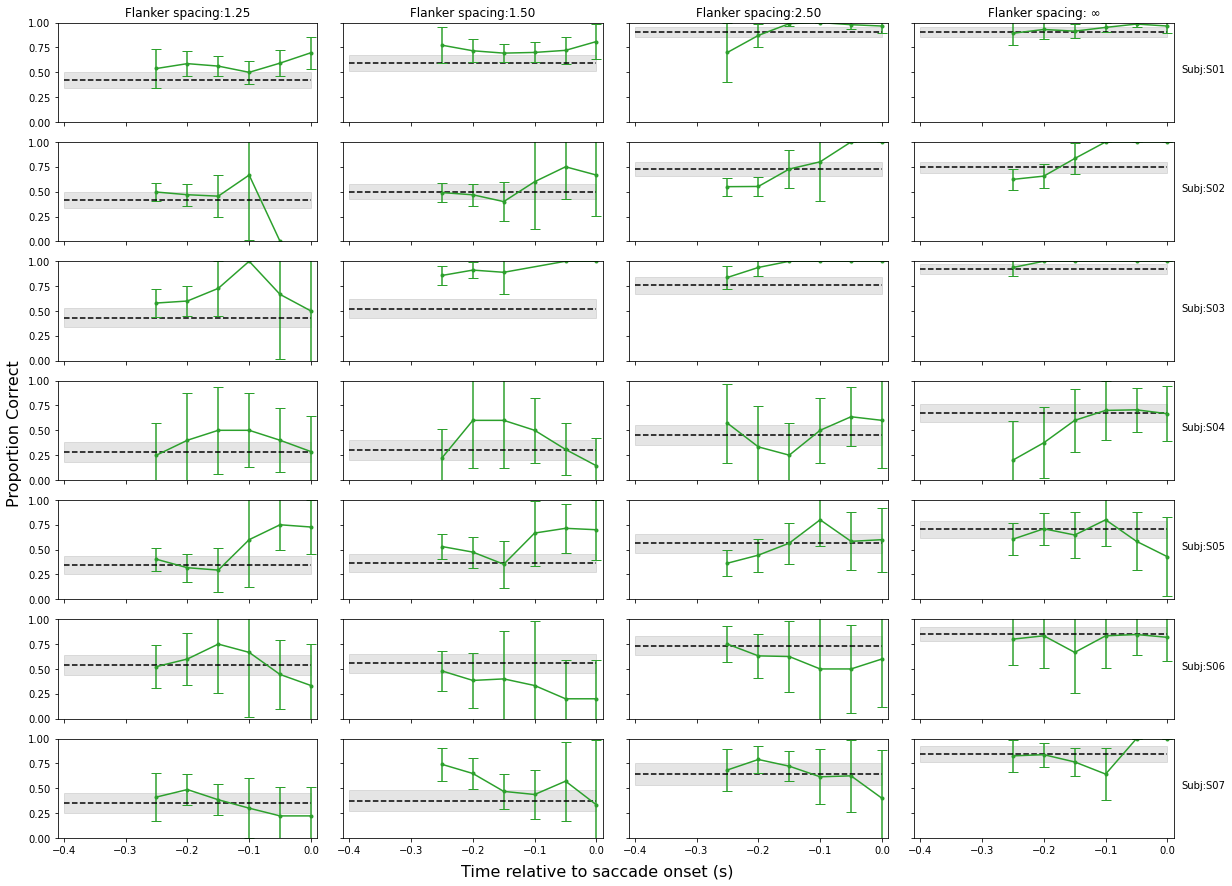

In [88]:
fig,axs=plt.subplots(nrows=7,ncols=4,sharey=True,sharex=True,figsize=(20,15))
spacings= [1.25 ,   1.5,   2.5 , 100.]
subs=BinDataPerf_sacc.subj_id_x.unique()

rowCounter=0
for row in axs:
    asub=subs[rowCounter]
    colCounter=0
    for col in row:
        aspacing=spacings[colCounter]
        #Microsaccade Condition
        df2_mean=BinDataPerf_sacc.query("spacing==@aspacing & subj_id_x==@asub").groupby(['binPt'])['corr'].mean().reset_index()
        # Compute CI
        df2_std=BinDataPerf_sacc.query("spacing==@aspacing & subj_id_x==@asub").groupby(['binPt'])['corr'].std().reset_index()
        df2_count=BinDataPerf_sacc.query("spacing==@aspacing & subj_id_x==@asub").groupby(['binPt'])['corr'].count().reset_index()
        x2=df2_std['binPt']
        ci2=1.96 * (df2_std['corr'])/np.sqrt(df2_count['corr']) 
        col.plot(df2_mean['binPt'],df2_mean['corr'],label='Congruent',color='C2',marker='.')
        #col.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.1)
        col.errorbar(df2_mean['binPt'],df2_mean['corr'],yerr=ci2,color='C2',ls = 'none',capsize = 5)

        #No saccade condition
        df3_mean=BinDataPerf_nosacc.query("spacing==@aspacing & subj_id==@asub")['corr'].mean()
        # Compute CI
        df3_std=BinDataPerf_nosacc.query("spacing==@aspacing & subj_id==@asub")['corr'].std()
        df3_count=BinDataPerf_nosacc.query("spacing==@aspacing & subj_id==@asub")['corr'].count()
        ci3=1.96 * (df3_std)/np.sqrt(df3_count) 
        xvalues=np.linspace(startPt,0,5)
        col.hlines(xmin=startPt,xmax=0,y=df3_mean,label='No Microsaccade',color='k',linestyle='--')
        col.fill_between(xvalues,(df3_mean+ci3),(df3_mean-ci3),color='k',alpha=0.1)
        # Add text to indicate condition
        if colCounter==3:
            col.text(col.get_xlim()[1]+0.0125,col.get_ylim()[1]-0.50,'Subj:%s'%(asub))
        if asub=='S01':
            if aspacing!=100:
                col.set_title("Flanker spacing:%.2f"%(aspacing))
            else:
                col.set_title("Flanker spacing: ∞")
        # Tweak axis for each plot
        col.set_xlim(startPt-0.010,0.010)
        col.set_ylim(0,1)
        colCounter+=1

    rowCounter+=1
fig.text(0.09,0.5,'Proportion Correct',size=16,va='center',rotation=90)
fig.text(0.5,0.09,'Time relative to saccade onset (s)',size=16,ha='center')

fig.subplots_adjust(hspace=0.2,wspace=0.1)

plt.savefig("..\Plots\PerformanceVTime_bySpacing&Ecc.pdf",dpi=1200,bbox_tight='inches')

In [ ]:
# Microsaccade metrics binned with respect to stimulus onset

# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.025 #seconds
binSize=0.100

startPt=-0.200
endPt=0.050
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
subs=sacc200msOnsetDF.subj_id_x.unique()
numelements=len(subs)*len(bins)
counter=1
# we create the necessary lists
# first we create lists for the experiment conditions
# First for the performance df
# No microsaccade condition list
BinDataPerf_sacc_combined=[]
BinDataPerf_nosacc_combined=[]
for asub in subs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        # Trials with microsaccades present
        print('%d/%d'%(counter,numelements),end='\r')
        perfDF=sacc200msOnsetDF.query("@start<relStimTime<@end & subj_id_x==@asub").drop_duplicates(subset=['code'])
        perfDF['binPt']=abin
        BinDataPerf_sacc_combined.append(perfDF)
        counter+=1
    #Trials W/o microsaccades 
    datanoSacc=behavDataNoMicrosaccade.query("subj_id==@asub")
    BinDataPerf_nosacc_combined.append(datanoSacc)
                    
BinDataPerf_sacc_combined=pd.concat(BinDataPerf_sacc_combined)
BinDataPerf_nosacc_combined=pd.concat(BinDataPerf_nosacc_combined)

In [ ]:
# Common permutation test for all conditions
# We run permutation test for each time point/bin step 
bins=BinDataPerf_sacc_combined.binPt.unique()
spacings=BinDataPerf_sacc_combined.spacing.unique()
binPtList=[]
spacingList=[]
p_vals_perf=[]
idx=0
# loop through each bin
for abin in bins:
    for aspacing in spacings:
        group1_perf=np.array(BinDataPerf_sacc_combined.query("binPt==@abin & spacing==@aspacing & corr<2")['corr'])
        group2_perf=np.array(BinDataPerf_nosacc_combined.query("spacing==@aspacing & corr<2")['corr'])
        res_perf=perm_test(group1_perf,group2_perf,10000,'mean',z_score=False)
        # append P val
        p_vals_perf.append(res_perf['p_val'])
        binPtList.append(abin)
        spacingList.append(aspacing)
p_val_df=pd.DataFrame(np.column_stack((binPtList,spacingList,p_vals_perf)),columns=['binPt','spacing','p_val_perf'])

c:\Users\krish\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\krish\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


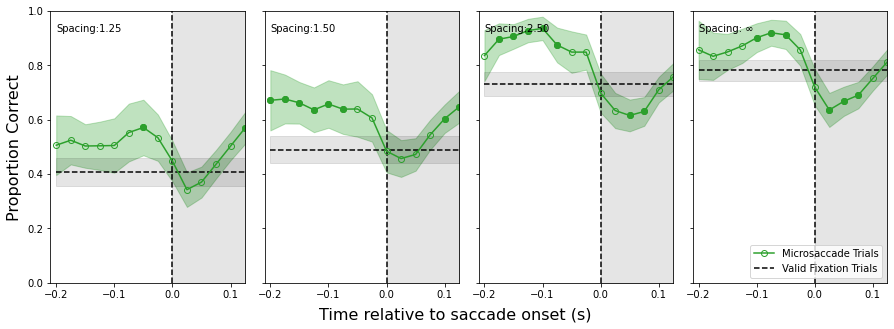

In [ ]:
from matplotlib.lines import lineStyles


fig,axs=plt.subplots(nrows=1,ncols=4,sharey=True,figsize=(15,5))
spacings= [1.25 ,   1.5,   2.5 , 100.]
subs=BinDataPerf_sacc_combined.subj_id_x.unique()
# We can either have a line plot with error bands or point plot with error bars
# 1. lineplot
# 2. pointplot
plotKind='linePlot'
colCounter=0
for col in axs:    
    aspacing=spacings[colCounter]
    #Microsaccade Condition
    subs_list=['S01','S02','S03','S04','S05','S06','S07']
    query_string="spacing==@aspacing & subj_id_x==@subs_list"
    df2_mean=BinDataPerf_sacc_combined.query(query_string).groupby(['binPt'])['corr'].mean().reset_index()
    # Compute CI
    df2_std=BinDataPerf_sacc_combined.query(query_string).groupby(['binPt'])['corr'].std().reset_index()
    df2_count=BinDataPerf_sacc_combined.query(query_string).groupby(['binPt'])['corr'].count().reset_index()
    x2=df2_std['binPt']
    ci2=1.96 * (df2_std['corr'])/np.sqrt(df2_count['corr']) 
    binVals=df2_mean['binPt']
    perfVals=df2_mean['corr']
    col.plot(binVals,perfVals,color='C2',marker='o',linestyle='-',markerfacecolor='none',label='Microsaccade Trials')
    for i in range(len(binVals)):
        binValue=binVals[i]
        a_pval=p_val_df.query("binPt==@binValue & spacing==@aspacing")['p_val_perf'].values[0]
        alpha_lvl=0.005
        if a_pval<alpha_lvl:
            col.plot(binVals[i],perfVals[i],marker='o',color='C2')
    if plotKind=='linePlot':
        col.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.3)
    elif plotKind=='pointPlot':
        col.errorbar(df2_mean['binPt'],df2_mean['corr'],yerr=ci2,color='C2',ls = 'none',capsize = 5)

    #No saccade condition
    query_string="spacing==@aspacing & subj_id==@subs_list"
    df3_mean=BinDataPerf_nosacc_combined.query(query_string)['corr'].mean()
    # Compute CI
    df3_std=BinDataPerf_nosacc_combined.query(query_string)['corr'].std()
    df3_count=BinDataPerf_nosacc_combined.query(query_string)['corr'].count()
    ci3=1.96 * (df3_std)/np.sqrt(df3_count) 
    xvalues=np.linspace(startPt,endPt,5)
    col.hlines(xmin=startPt,xmax=endPt,y=df3_mean,label='Valid Fixation Trials',color='k',ls='--')
    col.fill_between(xvalues,(df3_mean+ci3),(df3_mean-ci3),color='k',alpha=0.1)
    col.set_xlim(startPt-0.010,endPt-stepSize)
    col.set_ylim(0,1)
    if colCounter==3:
        col.legend(loc='lower right')
    if aspacing!=100:
        col.text(col.get_xlim()[0]+0.01,col.get_ylim()[1]-0.075,"Spacing:%.2f"%(aspacing))
    else:
        col.text(col.get_xlim()[0]+0.01,col.get_ylim()[1]-0.075,"Spacing: ∞")
    # Add vertical line for saccade onset & shaded region following saccade onset
    col.fill_betweenx(y=[0,1],x1=0,x2=endPt-stepSize,color=[0,0,0],alpha=0.1) 
    col.vlines(0,ymin=0,ymax=1,color='k',ls='--')
    colCounter+=1
        
fig.subplots_adjust(hspace=0.2,wspace=0.1)
fig.text(0.085,0.5,'Proportion Correct',size=16,va='center',rotation=90)
fig.text(0.5,0.025,'Time relative to saccade onset (s)',size=16,ha='center')

plt.savefig("..\Plots\PerformanceVTime_bySpacing_1by4.tiff",dpi=1200,bbox_inches='tight')

In [593]:
# Microsaccade metrics binned with respect to stimulus onset

# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.025 #seconds
binSize=0.100

startPt=-0.200
endPt=0.150
bins=np.arange(startPt,endPt,stepSize)
spacings=[1.25 ,   1.5,   2.5 , 100.]
binWidth=binSize/2
subs=saccFiltered.subj_id_x.unique()
numelements=len(subs)*len(bins)*len(spacings)
counter=1
# we create the necessary lists
# first we create lists for the experiment conditions
# First for the performance df
# No microsaccade condition list
BinDataZScore_sacc_combined=[]
BinDataZScore_nosacc_combined=[]
for aspacing in spacings:
    for asub in subs:
        for abin in bins:
            print("%d/%d"%(counter,numelements),end='\r')
            start=abin-binWidth
            end=abin+binWidth
            #Saccade Trials
            data_sacc=saccFiltered.query("@start<relStimTime<@end & subj_id_x==@asub & spacing==@aspacing")['corr']
            propVals=bootstrap_corr_to_propCor(data_sacc,num_boot=len(data_sacc))
            zScores=bootstrap_corr_to_z(data_sacc,num_boot=len(data_sacc))
            tempDF_sacc=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
            tempDF_sacc['spacing']=aspacing
            tempDF_sacc['binPt']=abin
            tempDF_sacc['subj']=asub
            BinDataZScore_sacc_combined.append(tempDF_sacc)
            counter+=1
        #No Saccade Trials
        data_nosacc=behavDataNoMicrosaccade.query("spacing==@aspacing & subj_id==@asub")['corr']
        propVals=bootstrap_corr_to_propCor(data_nosacc,num_boot=len(data_nosacc))
        zScores=bootstrap_corr_to_z(data_nosacc,num_boot=len(data_nosacc))
        tempDF_nosacc=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
        tempDF_nosacc['spacing']=aspacing
        tempDF_nosacc['subj']=asub
        BinDataZScore_nosacc_combined.append(tempDF_nosacc)
BinDataZScore_sacc_combined=pd.concat(BinDataZScore_sacc_combined)
BinDataZScore_nosacc_combined=pd.concat(BinDataZScore_nosacc_combined)

In [594]:
# Common permutation test for all conditions
# We run permutation test for each time point/bin step 
bins=BinDataZScore_sacc_combined.binPt.unique()
spacings=BinDataZScore_nosacc_combined.spacing.unique()
binPtList=[]
spacingList=[]
p_vals_perf=[]
idx=0
# loop through each bin
for abin in bins:
    for aspacing in spacings:
        group1_perf=np.array(BinDataZScore_sacc_combined.query("binPt==@abin & spacing==@aspacing")['zScores'])
        group2_perf=np.array(BinDataZScore_nosacc_combined.query("spacing==@aspacing")['zScores'])
        res_perf=perm_test(group1_perf,group2_perf,10000,'mean',z_score=False)
        # append P val
        p_vals_perf.append(res_perf['p_val'])
        binPtList.append(abin)
        spacingList.append(aspacing)
p_val_zScore_df=pd.DataFrame(np.column_stack((binPtList,spacingList,p_vals_perf)),columns=['binPt','spacing','p_val_perf'])

Text(0.5, 0.025, 'Time relative to saccade onset (s)')

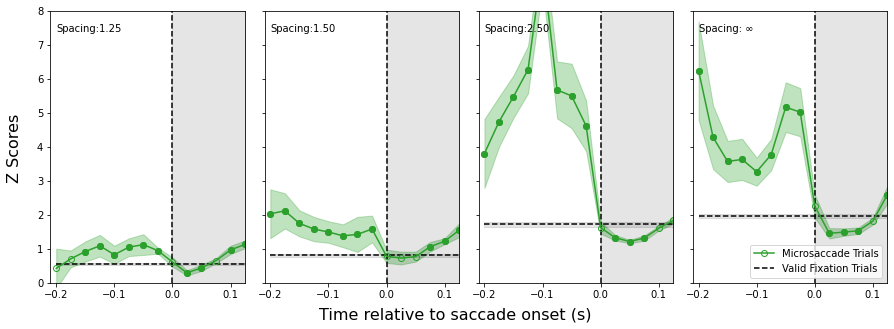

In [595]:
from matplotlib.lines import lineStyles


fig,axs=plt.subplots(nrows=1,ncols=4,sharey=True,figsize=(15,5))
spacings= [1.25 ,   1.5,   2.5 , 100.]
subs=BinDataPerf_sacc_combined.subj_id_x.unique()
# We can either have a line plot with error bands or point plot with error bars
# 1. lineplot
# 2. pointplot
plotKind='linePlot'
colCounter=0
for col in axs:    
    aspacing=spacings[colCounter]
    #Microsaccade Condition
    subs_list=['S01','S02','S03','S04','S05','S06','S07']
    query_string="spacing==@aspacing & subj==@subs_list"
    df2_mean=BinDataZScore_sacc_combined.query(query_string).groupby(['binPt'])['zScores'].mean().reset_index()
    # Compute CI
    df2_std=BinDataZScore_sacc_combined.query(query_string).groupby(['binPt'])['zScores'].std().reset_index()
    df2_count=BinDataZScore_sacc_combined.query(query_string).groupby(['binPt'])['zScores'].count().reset_index()
    x2=df2_std['binPt']
    ci2=1.96 * (df2_std['zScores'])/np.sqrt(df2_count['zScores']) 
    binVals=df2_mean['binPt']
    perfVals=df2_mean['zScores']
    col.plot(binVals,perfVals,color='C2',marker='o',linestyle='-',markerfacecolor='none',label='Microsaccade Trials')
    for i in range(len(binVals)):
        binValue=binVals[i]
        a_pval=p_val_zScore_df.query("binPt==@binValue & spacing==@aspacing")['p_val_perf'].values[0]
        alpha_lvl=0.001
        if a_pval<alpha_lvl:
            col.plot(binVals[i],perfVals[i],marker='o',color='C2')
    if plotKind=='linePlot':
        col.fill_between(x2,(df2_mean['zScores']+ci2),(df2_mean['zScores']-ci2),color='C2',alpha=0.3)
    elif plotKind=='pointPlot':
        col.errorbar(df2_mean['binPt'],df2_mean['zScores'],yerr=ci2,color='C2',ls = 'none',capsize = 5)

    #No saccade condition
    query_string="spacing==@aspacing & subj==@subs_list"
    df3_mean=BinDataZScore_nosacc_combined.query(query_string)['zScores'].mean()
    # Compute CI
    df3_std=BinDataZScore_nosacc_combined.query(query_string)['zScores'].std()
    df3_count=BinDataZScore_nosacc_combined.query(query_string)['zScores'].count()
    ci3=1.96 * (df3_std)/np.sqrt(df3_count) 
    xvalues=np.linspace(startPt,endPt,5)
    col.hlines(xmin=startPt,xmax=endPt,y=df3_mean,label='Valid Fixation Trials',color='k',ls='--')
    col.fill_between(xvalues,(df3_mean+ci3),(df3_mean-ci3),color='k',alpha=0.1)
    ymax_val=8
    col.set_xlim(startPt-0.010,endPt-stepSize)
    col.set_ylim(0,ymax_val)
    if colCounter==3:
        col.legend(loc='lower right')
    if aspacing!=100:
        col.text(col.get_xlim()[0]+0.01,col.get_ylim()[1]-0.6,"Spacing:%.2f"%(aspacing))
    else:
        col.text(col.get_xlim()[0]+0.01,col.get_ylim()[1]-0.6,"Spacing: ∞")
    # Add vertical line for saccade onset & shaded region following saccade onset
    col.fill_betweenx(y=[0,ymax_val],x1=0,x2=endPt-stepSize,color=[0,0,0],alpha=0.1) 
    col.vlines(0,ymin=0,ymax=ymax_val,color='k',ls='--')
    colCounter+=1
        
fig.subplots_adjust(hspace=0.2,wspace=0.1)
fig.text(0.085,0.5,'Z Scores',size=16,va='center',rotation=90)
fig.text(0.5,0.025,'Time relative to saccade onset (s)',size=16,ha='center')

In [596]:
# Compute difference in Z Scores between groups
subs=BinDataZScore_sacc_combined.subj.unique()
spacings=BinDataZScore_sacc_combined.spacing.unique()
bins=BinDataZScore_sacc_combined.binPt.unique()

# Create empty list for values
spacing_list=[]
sub_list=[]
bin_list=[]
diff_zScores=[]

for aspacing in spacings:
    for asub in subs:
        noSaccDF=BinDataZScore_nosacc_combined.query("spacing==@aspacing & subj==@asub")['zScores']
        for abin in bins:
            saccDF=BinDataZScore_sacc_combined.query("spacing==@aspacing & subj==@asub and binPt==@abin")['zScores']
            for i in range(1000):
                new_df_sacc = saccDF.sample(n=len(saccDF),replace=True)
                new_df_nosacc=noSaccDF.sample(n=len(noSaccDF),replace=True)
                # get diff in z scores
                zscore_diff=np.mean(new_df_sacc)-np.mean(new_df_nosacc)
                # append to lists
                spacing_list.append(aspacing)
                sub_list.append(asub)
                bin_list.append(abin)
                diff_zScores.append(zscore_diff)
zScoreDiff_DF=pd.DataFrame(np.column_stack((spacing_list,sub_list,bin_list,diff_zScores)),columns=['spacing','subj','binPt','zScoreDiff'])
zScoreDiff_DF['zScoreDiff']=zScoreDiff_DF['zScoreDiff'].astype(float)
zScoreDiff_DF['binPt']=zScoreDiff_DF['binPt'].astype(float)
zScoreDiff_DF['spacing']=zScoreDiff_DF['spacing'].astype(float)

Text(0.5, 0.025, 'Time relative to saccade onset (s)')

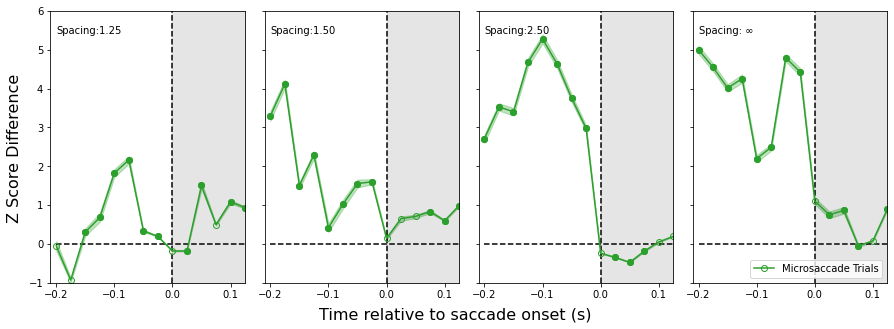

In [597]:
from matplotlib.lines import lineStyles


fig,axs=plt.subplots(nrows=1,ncols=4,sharey=True,figsize=(15,5))
spacings= [1.25 ,   1.5,   2.5 , 100.]
subs=BinDataPerf_sacc_combined.subj_id_x.unique()
# We can either have a line plot with error bands or point plot with error bars
# 1. lineplot
# 2. pointplot
plotKind='linePlot'
colCounter=0
for col in axs:    
    aspacing=spacings[colCounter]
    #Microsaccade Condition
    subs_list=['S01','S02','S03','S04','S05','S06','S07']
    query_string="spacing==@aspacing"# & subj==@subs_list"
    df2_mean=zScoreDiff_DF.query(query_string).groupby(['binPt'])['zScoreDiff'].mean().reset_index()
    # Compute CI
    df2_std=zScoreDiff_DF.query(query_string).groupby(['binPt'])['zScoreDiff'].std().reset_index()
    df2_count=zScoreDiff_DF.query(query_string).groupby(['binPt'])['zScoreDiff'].count().reset_index()
    x2=df2_std['binPt']
    ci2=1.96 * (df2_std['zScoreDiff'])/np.sqrt(df2_count['zScoreDiff']) 
    binVals=df2_mean['binPt']
    perfVals=df2_mean['zScoreDiff']
    col.plot(binVals,perfVals,color='C2',marker='o',linestyle='-',markerfacecolor='none',label='Microsaccade Trials')
    for i in range(len(binVals)):
        binValue=binVals[i]
        a_pval=p_val_zScore_df.query("binPt==@binValue & spacing==@aspacing")['p_val_perf'].values[0]
        alpha_lvl=0.001
        if a_pval<alpha_lvl:
            col.plot(binVals[i],perfVals[i],marker='o',color='C2')
    if plotKind=='linePlot':
        col.fill_between(x2,(df2_mean['zScoreDiff']+ci2),(df2_mean['zScoreDiff']-ci2),color='C2',alpha=0.3)
    elif plotKind=='pointPlot':
        col.errorbar(df2_mean['binPt'],df2_mean['zScoreDiff'],yerr=ci2,color='C2',ls = 'none',capsize = 5)

    ymax_val=6
    col.set_xlim(startPt-0.010,endPt-stepSize)
    col.set_ylim(-1,ymax_val)
    if colCounter==3:
        col.legend(loc='lower right')
    if aspacing!=100:
        col.text(col.get_xlim()[0]+0.01,col.get_ylim()[1]-0.6,"Spacing:%.2f"%(aspacing))
    else:
        col.text(col.get_xlim()[0]+0.01,col.get_ylim()[1]-0.6,"Spacing: ∞")
    # Add vertical line for saccade onset & shaded region following saccade onset
    col.fill_betweenx(y=[-1,ymax_val],x1=0,x2=endPt-stepSize,color=[0,0,0],alpha=0.1) 
    col.vlines(0,ymin=-1,ymax=ymax_val,color='k',ls='--')
    col.hlines(xmin=startPt,xmax=endPt-stepSize,y=0,color='k',ls='--')
    colCounter+=1
        
fig.subplots_adjust(hspace=0.2,wspace=0.1)
fig.text(0.085,0.5,'Z Score Difference',size=16,va='center',rotation=90)
fig.text(0.5,0.025,'Time relative to saccade onset (s)',size=16,ha='center')

In [598]:
g=sns.FacetGrid(size=4, aspect=1, col="spacing",row='subj',
               data=binSacc_subj)
g.map(sns.lineplot,'binPt','propCorr',ci="sd",color='C1',label='Microsaccade',marker='o')
spacings=binSacc_subj['spacing'].unique()
spacings.sort()
spacingList=np.concatenate((spacings,spacings,spacings,spacings,spacings,spacings,spacings))
subjList=binSacc_subj.subj.unique()
subjList=np.repeat(subjList,4)
axCounter=0
axes = g.fig.axes
for ax in axes:
    spacingVal=spacingList[axCounter]
    subj_id=subjList[axCounter]
    yVal=binFix_subj.query("spacing==@spacingVal and subj==@subj_id")['propCorr']
    # We compute CI
    ci=sns.utils.ci(sns.algorithms.bootstrap(yVal))
    diff=yVal.std()#np.abs(yVal.mean()-ci[0])
    ax.hlines(xmin=startPt,xmax=endPt,y=yVal.mean(),linestyle='--',label='No Microsaccade')
    x=linspace(startPt,endPt,10)
    y=np.repeat(yVal.mean(),len(x))
    ax.fill_between(x, (y-diff),(y+diff), color='grey',alpha=.1)
    # Add a vertical line to represent saccade onset
    ax.vlines(ymin=0,ymax=1,x=0,color='k',linestyle='--')
    axCounter+=1

NameError: name 'binSacc_subj' is not defined

In [ ]:
g=sns.FacetGrid(size=4, aspect=1, col="spacing",row='subj',
               data=binSacc_subj)
g.map(sns.lineplot,'binPt','zScores',ci="sd",color='C1',label='Microsaccade',marker='o')
spacings=binSacc_subj['spacing'].unique()
spacings.sort()
spacingList=np.concatenate((spacings,spacings,spacings,spacings,spacings,spacings,spacings))
subjList=binSacc_subj.subj.unique()
subjList=np.repeat(subjList,4)
axCounter=0
axes = g.fig.axes
for ax in axes:
    spacingVal=spacingList[axCounter]
    subj_id=subjList[axCounter]
    yVal=binFix_subj.query("spacing==@spacingVal and subj==@subj_id")['zScores']
    # We compute CI
    ci=sns.utils.ci(sns.algorithms.bootstrap(yVal))
    diff=yVal.std()#np.abs(yVal.mean()-ci[0])
    ax.hlines(xmin=startPt,xmax=endPt,y=yVal.mean(),linestyle='--',label='No Microsaccade')
    x=linspace(startPt,endPt,10)
    y=np.repeat(yVal.mean(),len(x))
    ax.fill_between(x, (y-diff),(y+diff), color='grey',alpha=.1)
    # Add a vertical line to represent saccade onset
    ax.vlines(ymin=-4,ymax=10,x=0,color='k',linestyle='--')
    axCounter+=1

In [ ]:
# Equal bin width method:
# Cons: Every bin would have different number of samples/trials\n",
#segregate by spacing
startPt=-0.400
stepSize=0.025#0.025
binSize=0.075#0.075
endPt=0.050
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
subs=saccadeData['subj_id_x'].unique()
spacings=[  1.25,   2.5 ,   1.5 , 100.]
nums=saccadeData['target'].unique()
counter=1
total_iter=len(bins)*len(spacings)
#second we create lists for the outcome/microsaccade metrics
binSacc=[]
for abin in bins:
    start=abin-binWidth
    end=abin+binWidth
    for aspacing in spacings:
        print("%d/%d"%(counter,total_iter),end='\r')
        data=saccadeData.query("@start<relStimTime<@end & spacing==@aspacing & trialValidity=='valid'")['corr']
        # we get bootstrapped proportion correct from response values and create a df
        propVals=bootstrap_corr_to_propCor(data)
        zScores=bootstrap_corr_to_z(data)
        tempDF=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
        tempDF['binPt']=abin
        tempDF['spacing']=aspacing
        binSacc.append(tempDF)
        counter+=1

binSacc=pd.concat(binSacc)
                                     
# Do the same thing for the fixation condition
counter=1
total_iter=len(spacings)
# create an empty list for fixation condition
binFix=[]
for aspacing in spacings:
    print("%d/%d"%(counter,total_iter),end='\r')
    data=behavDataNoMicrosaccade.query("spacing==@aspacing & trialValidity=='valid'")['corr']
    # we get bootstrapped proportion correct from response values and create a df
    propVals=bootstrap_corr_to_propCor(data)
    zScores=bootstrap_corr_to_z(data)
    tempDF=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
    tempDF['spacing']=aspacing
    binFix.append(tempDF)
    counter+=1
binFix=pd.concat(binFix)
# add a column that would used for plotting
binFix['binPt']=-0.200

In [ ]:
g=sns.FacetGrid(size=4, aspect=1, hue="spacing",
               data=binSacc)
g.map(sns.lineplot,'binPt','zScores',ci="sd",label='Microsaccade',marker='o')
g.add_legend()
spacingList=binSacc['spacing'].unique()
spacingList.sort()
axCounter=0
axes = g.fig.axes
# for ax in axes:
#     spacingVal=spacingList[axCounter]
#     yVal=binFix.query("spacing==@spacingVal")['zScores']
#     # We compute CI
#     ci=sns.utils.ci(sns.algorithms.bootstrap(yVal))
#     diff=yVal.std()#np.abs(yVal.mean()-ci[0])
#     ax.hlines(xmin=startPt,xmax=endPt,y=yVal.mean(),linestyle='--',label='No Microsaccade')
#     x=linspace(startPt,endPt,10)
#     y=np.repeat(yVal.mean(),len(x))
#     ax.fill_between(x, (y-diff),(y+diff), color='grey',alpha=.1)
#     # Add a vertical line to represent saccade onset
#     ax.vlines(ymin=0,ymax=5,x=0,color='k',linestyle='--')
#     axCounter+=1

## Eye trace with event markers

In [ ]:
codeListTrial=eyepos['code'].unique()

def plot_func_trial(code_idx):
    code=codeListTrial[int(code_idx)]
    print(code)
    data=eyepos.query("code==@code")
    SaccFiltered=microSaccFiltered.query("code==@code")
    driftFiltered=driftData.query("code==@code")
    stimTime=markerData.query("code==@code")
    plt.figure(figsize=(8,5))
    plt.plot(data['time'],data['xpos'],'.-',label='Horizontal')
    plt.plot(data['time'],data['ypos'],'.-',color='C1',label='Vertical')
    ax=plt.axvline(x=stimTime['stimulusOnsetTime'].values[0],ymin=0,ymax=1,color='C2',ls='--',label='Cue Onset')
    ax=plt.axvline(x=stimTime['stimulusOnsetTime'].values[1],ymin=0,ymax=1,color='k',ls='--',label='Stimulus Onset')
#     ax1=plt.axvline(x=stimTime['cueOnsetTime'].values,ymin=0,ymax=1,color='k',ls='--',label='Cue Onset')
    if len(SaccFiltered)>0:
        for i in range(len(SaccFiltered)):
            startTime=SaccFiltered['onsetTime'].iloc[i]
            endTime=SaccFiltered['offsetTime'].iloc[i]
            filteredData=data.query("time>@startTime & time<@endTime")
            x=filteredData['time']
            y1=filteredData['xpos']
            y2=filteredData['ypos']
            plt.plot(x,y1,'v',color='C0',label='Microsaccade' if i==0 else "")
            plt.plot(x,y2,'v',color='C1')

    if len(driftFiltered)>0:
        for k in range(len(driftFiltered)):
            startTime=driftFiltered['onsetTime'].iloc[k]
            endTime=driftFiltered['offsetTime'].iloc[k]
            filteredData=data.query("time>@startTime & time<@endTime")
            x=filteredData['time']
            y1=filteredData['xpos']
            y2=filteredData['ypos']
            plt.plot(x,y1,'.',color='C0',label='Drifts' if k==0 else "")
            plt.plot(x,y2,'.',color='C1')
    plt.xlabel('Time (s)',size=12)
    plt.ylabel('Eye Position (degrees)',size=12)
    # plt.xlim(0,1.3)
    plt.legend()
    # plt.savefig('..\Plots\SampleEyeTraceTrial.svg',bbox_tight=True,dpi=1200)

slider_max=len(codeListTrial)-1
interact(plot_func_trial, code_idx = widgets.FloatSlider(value=0,
                                               min=0,
                                               max=slider_max,
                                               step=1))

In [ ]:
# First look at ground truth saccade latency
codeList=microSaccFiltered['code'].unique()
latencyList=[]
code_list=[]
subj_id_list=[]
for acode in codeList:
    try:
        cueTime=markerData.query("code==@acode")['stimulusOnsetTime'].iloc[0]
        maxWindow=cueTime+0.800
        saccadeTime=microSaccData.query("code==@acode & onsetTime>@cueTime+0.100 & onsetTime<@maxWindow")['onsetTime'].iloc[0]
        subj_id=microSaccData.query("code==@acode")['subj_id'].unique()
        latency=saccadeTime-cueTime
        latencyList.append(latency)
        code_list.append(acode)
        subj_id_list.append(subj_id)
    except:
        pass
latencyData=pd.DataFrame(np.column_stack((latencyList,code_list,subj_id_list)),columns=['latency','code','subj_id'])
latencyData['latency']=latencyData['latency'].astype(float)

In [ ]:
latencyData.groupby('subj_id')['latency'].plot(kind='hist')
plt.legend()